(target-platform-paper-social-analysis-pt2)=
# Platform paper social experiment analysis: Part 2

This example continues the behavioural data analysis from experiments `social0.2`, `social0.3`, and `social0.4`, introduced in [](target-platform-paper-social-analysis-pt1), where we outlined the experimental design and provided provided setup instructions for running the analysis.

Here, we assume the environment is already active and focus on comparing _solo and social behaviours_—specifically exploration, sleep, foraging, and drinking—as well as _solo and social learning_, including changes in foraging efficiency over time and patch preference, quantified as the probability of being in the poor patch.

:::{seealso}
[](target-dj-compute-behav-bouts) and [](target-dj-fetching-data) for details on how we quantify exploration, sleep, foraging, and drinking bouts based on position data.
:::

## Import libraries and define variables and helper functions

In [1]:
from pathlib import Path
from warnings import warn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.ndimage import uniform_filter1d
from tqdm.auto import tqdm


The hidden cells below define helper functions, constants, and setup variables used throughout the notebook.  
They **must be run**, but are hidden for readability.  


In [3]:
# Plot settings
sns.set_style("ticks")

# Constants
cm2px = 5.2  # 1 cm = 5.2 px roughly in aeon arenas
light_off, light_on = 7, 20  # 7am to 8pm

subject_colors = sns.color_palette("Paired")
patch_colors = sns.color_palette()
patch_markers = [
    "circle",
    "bowtie",
    "square",
    "hourglass",
    "diamond",
    "cross",
    "x",
    "triangle",
    "star",
]
patch_markers_symbols = ["●", "⧓", "■", "⧗", "♦", "✖", "×", "▲", "★"]
patch_markers_dict = dict(zip(patch_markers, patch_markers_symbols, strict=False))
patch_markers_linestyles = ["solid", "dash", "dot", "dashdot", "longdashdot"]
subject_markers_linestyles = patch_markers_linestyles.copy()
patch_type_mean_map = {100: "l", 300: "m", 500: "h", 200: "l", 600: "m", 1000: "h"}
patch_type_rate_map = {
    0.01: "l",
    0.0033: "m",
    0.002: "h",
    0.005: "l",
    0.00167: "m",
    0.001: "h",
}

experiments = [
    {
        "name": "social0.2-aeon3",
        "presocial_start": "2024-01-31 11:00:00",
        "presocial_end": "2024-02-08 15:00:00",
        "social_start": "2024-02-09 16:00:00",
        "social_end": "2024-02-23 13:00:00",
        "postsocial_start": "2024-02-25 17:00:00",
        "postsocial_end": "2024-03-02 14:00:00",
    },
    {
        "name": "social0.2-aeon4",
        "presocial_start": "2024-01-31 11:00:00",
        "presocial_end": "2024-02-08 15:00:00",
        "social_start": "2024-02-09 17:00:00",
        "social_end": "2024-02-23 12:00:00",
        "postsocial_start": "2024-02-25 18:00:00",
        "postsocial_end": "2024-03-02 13:00:00",
    },
    {
        "name": "social0.3-aeon3",
        "presocial_start": "2024-06-08 19:00:00",
        "presocial_end": "2024-06-17 13:00:00",
        "social_start": "2024-06-25 11:00:00",
        "social_end": "2024-07-06 13:00:00",
        "postsocial_start": "2024-07-07 16:00:00",
        "postsocial_end": "2024-07-14 14:00:00",
    },
    {
        "name": "social0.4-aeon3",
        "presocial_start": "2024-08-16 17:00:00",
        "presocial_end": "2024-08-24 10:00:00",
        "social_start": "2024-08-28 11:00:00",
        "social_end": "2024-09-09 13:00:00",
        "postsocial_start": "2024-09-09 18:00:00",
        "postsocial_end": "2024-09-22 16:00:00",
    },
    {
        "name": "social0.4-aeon4",
        "presocial_start": "2024-08-16 15:00:00",
        "presocial_end": "2024-08-24 10:00:00",
        "social_start": "2024-08-28 10:00:00",
        "social_end": "2024-09-09 01:00:00",
        "postsocial_start": "2024-09-09 15:00:00",
        "postsocial_end": "2024-09-22 16:00:00",
    },
]

periods = ["social", "postsocial"]

# Define the possible combos of social and light
combos = [
    (True, True),  # Social + Light
    (True, False),  # Social + Dark
    (False, True),  # Solo + Light
    (False, False),  # Solo + Dark
]

# Define colors based on light condition (light=blue, dark=orange)
colors = {
    True: "#1f77b4",  # Blue for light conditions
    False: "#ff7f0e",  # Orange for dark conditions
}

# Define hatch patterns based on social condition
hatches = {
    True: "///",  # Hatched pattern for social
    False: None,  # No pattern (solid) for solo
}

labels = ["Social-Light", "Social-Dark", "Solo-Light", "Solo-Dark"]

In [4]:
def load_data_from_parquet(
    experiment_name: str | None,
    period: str | None,
    data_type: str,
    data_dir: Path,
    set_time_index: bool = False,
) -> pd.DataFrame:
    """Loads saved data from parquet files.

    Args:
        experiment_name (str, optional): Filter by experiment name. If None, load all experiments.
        period (str, optional): Filter by period (presocial, social, postsocial). If None, load all periods.
        data_type (str): Type of data to load (position, patch, foraging, rfid, sleep, explore)
        data_dir (Path): Directory containing parquet files.
        set_time_index (bool, optional): If True, set 'time' column as DataFrame index.

    Returns:
        pd.DataFrame: Combined DataFrame of all matching parquet files.
    """
    if not data_dir.exists():
        print(f"Directory {data_dir} does not exist. No data files found.")
        return pd.DataFrame()
    # Create pattern based on filters
    pattern = ""
    if experiment_name:
        pattern += f"{experiment_name}_"
    else:
        pattern += "*_"
    if period:
        pattern += f"{period}_"
    else:
        pattern += "*_"
    pattern += f"{data_type}.parquet"

    # Find matching files
    matching_files = list(data_dir.glob(pattern))
    if not matching_files:
        print(f"No matching data files found with pattern: {pattern}")
        return pd.DataFrame()

    print(f"Found {len(matching_files)} matching files")
    # Load and concatenate matching files
    dfs = []
    total_rows = 0
    for file in matching_files:
        print(f"Loading {file}...")
        df = pd.read_parquet(file)
        total_rows += len(df)
        dfs.append(df)
        print(f"  Loaded {len(df)} rows")
    
    # Combine data
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        if set_time_index and "time" in combined_df.columns:
            combined_df = combined_df.set_index("time")
        print(f"Combined data: {len(combined_df)} rows")
        return combined_df
    else:
        return pd.DataFrame()


def load_experiment_data(
    data_dir: Path,
    experiment: dict | None = None,
    periods: list | None = None,
    data_types: list[str] = ["rfid", "position"],
    trim_days: int | None = None,
) -> dict:
    """Load all data types for specified periods of an experiment.

    Parameters:
    - experiment: experiment dict with period start/end times
    - periods: list of periods to load
    - data_types: list of data types to load
    - data_dir: directory containing data files
    - trim_days: Optional number of days to trim from start (None = no trim)

    Returns:
    - Dictionary containing dataframes for each period/data type combination
    """
    result = {}

    if periods is None:
        periods = [None]

    for period in periods:
        for data_type in data_types:
            print(f"Loading {period} {data_type} data...")
            # Load data
            experiment_name = experiment["name"] if experiment is not None else None
            df = load_data_from_parquet(
                experiment_name=experiment_name,
                period=period,
                data_type=data_type,
                data_dir=data_dir,
                set_time_index=(data_type == "position"),
            )
            # Trim if requested
            if trim_days is not None and len(df) > 0:
                if data_type == "rfid":
                    start_time = df["chunk_start"].min()
                    end_time = start_time + pd.Timedelta(days=trim_days)
                    df = df[df["chunk_start"] < end_time]
                if data_type == "foraging":
                    start_time = df["start"].min()
                    end_time = start_time + pd.Timedelta(days=trim_days)
                    df = df[df["start"] < end_time]
                if data_type == "position":
                    start_time = df.index.min()
                    end_time = start_time + pd.Timedelta(days=trim_days)
                    df = df.loc[df.index < end_time]
                print(f"  Trimmed to {trim_days} days: {len(df)} records")
            # Store in result
            key = f"{period}_{data_type}"
            result[key] = df
            # For position data, handle duplicates
            if data_type == "position" and len(df) > 0:
                original_len = len(df)
                df = df.reset_index()
                df = df.drop_duplicates(subset=["time", "identity_name"])
                df = df.set_index("time")
                result[key] = df
                if len(df) < original_len:
                    print(f"  Removed duplicates: {original_len} -> {len(df)}")

    return result


:::{note}
Change `data_dir` to the path where your local dataset (the parquet files) is stored.
:::

In [5]:
# CHANGE THIS TO YOUR DATA DIRECTORY
# TODO: RESET TO ""
data_dir = Path("/ceph/aeon/aeon/share/globus/platform_paper_social_analysis_datasets")

## Solo vs. social behaviours

### Exploring

We compare subjects' exploratory behaviour in solo and social conditions across light and dark cycles, and show that subjects in the social condition exhibit a stronger exploratory drive, covering greater distances.

#### Distance travelled

This hidden cell is **optional**. 
It performs per-subject hourly distance computations across all experiments and periods based on [multi-animal tracking](target-multianimal-tracking) data.
As the computation is slow, we have **precomputed the results** and saved them to Parquet.

In [ ]:
# Final df:
# rows = hour-datetime,
# columns = distance, exp, social-bool, subject, light-bool
dist_trav_hour_df = pd.DataFrame(
    columns=["hour", "distance", "exp", "social", "subject", "light"]
)
# For each period
# Load pos data
# Split into individual dfs
# If social, excise swaps
# Smooth down to 1s
# Calculate hour-by-hour distance traveled, and put into final df
exp_pbar = tqdm(experiments, desc="Experiments", position=0, leave=True)
for exp in exp_pbar:
    period_pbar = tqdm(periods, desc="Periods", position=1, leave=True)
    for period in period_pbar:
        pos_df = load_data_from_parquet(
            experiment_name=exp["name"],
            period=period,
            data_type="position",
            data_dir=data_dir,
            set_time_index=True,
        )
        for subject in pos_df["identity_name"].unique():
            pos_df_subj = pos_df[pos_df["identity_name"] == subject]
            pos_df_subj = pos_df_subj.resample("200ms").first().dropna(subset=["x"])
            pos_df_subj[["x", "y"]] = pos_df_subj[["x", "y"]].rolling("1s").mean()
            pos_df_subj = pos_df_subj.resample("1s").first().dropna(subset=["x"])
            pos_df_subj["distance"] = np.sqrt(
                (pos_df_subj["x"].diff() ** 2) + (pos_df_subj["y"].diff() ** 2)
            )
            pos_df_subj.at[pos_df_subj.index[0], "distance"] = 0
            pos_df_subj["distance"] /= cm2px * 100  # convert to m
            pos_df_subj["hour"] = pos_df_subj.index.floor("h")
            pos_df_subj_hour = (
                pos_df_subj.groupby("hour")["distance"].sum().reset_index()
            )
            pos_df_subj_hour["exp"] = exp["name"]
            pos_df_subj_hour["social"] = period == "social"
            pos_df_subj_hour["subject"] = subject
            hour = pos_df_subj_hour["hour"].dt.hour
            pos_df_subj_hour["light"] = ~((hour > light_off) & (hour < light_on))
            dist_trav_hour_df = pd.concat(
                [dist_trav_hour_df, pos_df_subj_hour], ignore_index=True
            )

# Save as parquet
dist_trav_hour_df.to_parquet(
    data_dir / "for_plots" / "dist_trav_hour_df.parquet",
    engine="pyarrow",
    compression="snappy",
    index=False,
)

Here we will load and visualise the precomputed distances from the aforementioned Parquet file.

In [61]:
# Load the parquet file
dist_trav_hour_df = pd.read_parquet(
    data_dir / "for_plots" / "dist_trav_hour_df.parquet",
    engine="pyarrow",
)
dist_trav_hour_df

,hour,distance,exp,social,subject,light
0,2024-01-31 11:00:00,214.375787,social0.2-aeon3,False,BAA-1104045,False
1,2024-01-31 12:00:00,358.672416,social0.2-aeon3,False,BAA-1104045,False
2,2024-01-31 13:00:00,301.952548,social0.2-aeon3,False,BAA-1104045,False
3,2024-01-31 14:00:00,284.154738,social0.2-aeon3,False,BAA-1104045,False
4,2024-01-31 15:00:00,420.268372,social0.2-aeon3,False,BAA-1104045,False
...,...,...,...,...,...,...
4840,2024-09-22 13:00:00,263.921865,social0.4-aeon4,False,BAA-1104797,False
4841,2024-09-22 14:00:00,316.511526,social0.4-aeon4,False,BAA-1104797,False
4842,2024-09-22 15:00:00,281.001766,social0.4-aeon4,False,BAA-1104797,False
4843,2024-09-22 16:00:00,171.733688,social0.4-aeon4,False,BAA-1104797,False


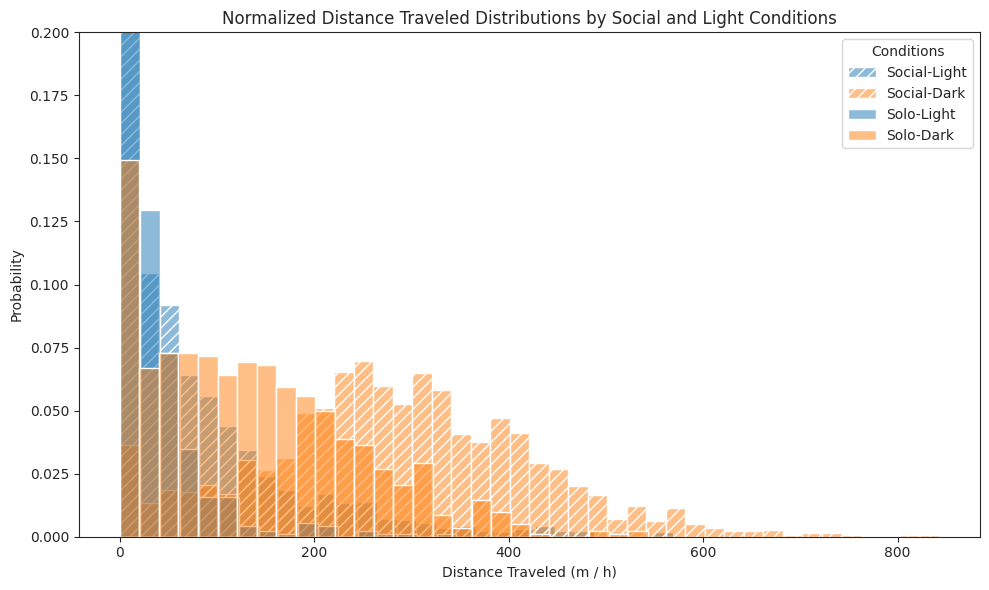

In [11]:
# Plot histograms for each combination
fig, ax = plt.subplots(figsize=(10, 6))
for i, (social_val, light_val) in enumerate(combos):
    # Filter data for this combination
    subset = dist_trav_hour_df[
        (dist_trav_hour_df["social"] == social_val)
        & (dist_trav_hour_df["light"] == light_val)
    ]
    # Plot normalized histogram
    hist = sns.histplot(
        data=subset,
        x="distance",
        stat="probability",  # This normalizes the histogram
        alpha=0.5,
        color=colors[light_val],
        label=labels[i],
        # kde=True,  # Add kernel density estimate
        common_norm=False,  # Ensure each histogram is normalized separately
        axes=ax,
        binwidth=20,
    )
    # Set hatch pattern for bars
    if hatches[social_val]:
        for bar in hist.patches:
            bar.set_hatch(hatches[social_val])

ax.set_title(
    "Normalized Distance Traveled Distributions by Social and Light Conditions"
)
ax.set_xlabel("Distance Traveled (m / h)")
ax.set_ylabel("Probability")
ax.legend(title="Conditions")
ax.set_ylim(0, 0.2)
plt.tight_layout()
plt.show()

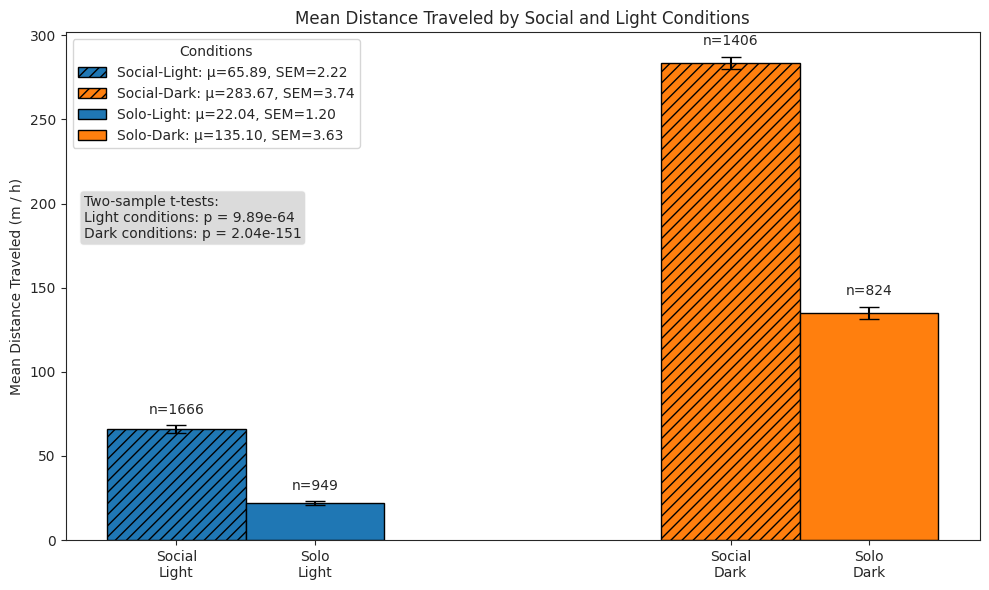

In [8]:
# Plot bar plot of means 
fig, ax = plt.subplots(figsize=(10, 6))
summary_data = []
for social_val in [True, False]:
    for light_val in [True, False]:
        subset = dist_trav_hour_df[
            (dist_trav_hour_df["social"] == social_val)
            & (dist_trav_hour_df["light"] == light_val)
        ]
        mean_dist = subset["distance"].mean()
        sem_dist = subset["distance"].sem()
        n_samples = len(subset)
        summary_data.append(
            {
                "social": social_val,
                "light": light_val,
                "mean_distance": mean_dist,
                "sem": sem_dist,
                "condition": (
                    f"{'Social' if social_val else 'Solo'}-"
                    f"{'Light' if light_val else 'Dark'}",
                ),
                "n": n_samples,
            }
        )
summary_df = pd.DataFrame(summary_data)
# Set up positions for the bars
bar_width = 0.5
x_pos = np.array([0.25, 2.25, 0.75, 2.75])  # create two groups with a gap in the middle
# Plot bars
for i, row in enumerate(summary_data):
    pos = x_pos[i]
    social_val = row["social"]
    light_val = row["light"]
    bar = ax.bar(
        pos,
        row["mean_distance"],
        bar_width,
        yerr=row["sem"],
        color=colors[light_val],
        edgecolor="black",
        capsize=7,
        label=f"{row['condition'][0]}: μ={row['mean_distance']:.2f}, SEM={row['sem']:.2f}",
    )
    # Apply hatching for social conditions
    if hatches[social_val]:
        bar[0].set_hatch(hatches[social_val])
    # Add sample size as text above each bar
    sample_size_txt = ax.text(
        pos,
        row["mean_distance"] + row["sem"] + 5,
        f"n={row['n']}",
        ha="center",
        va="bottom",
    )

ax.set_ylabel("Mean Distance Traveled (m / h)")
ax.set_xticks(x_pos)
ax.set_xticklabels(["Social\nLight", "Social\nDark", "Solo\nLight", "Solo\nDark"])
ax.set_title("Mean Distance Traveled by Social and Light Conditions")
ax.legend(title="Conditions", loc="upper left")
# Add stats tests
light_social = dist_trav_hour_df.query("social and light")["distance"]
light_solo   = dist_trav_hour_df.query("not social and light")["distance"]
dark_social  = dist_trav_hour_df.query("social and not light")["distance"]
dark_solo    = dist_trav_hour_df.query("not social and not light")["distance"]
light_stat, light_p = stats.ttest_ind(
    light_social, light_solo, alternative="two-sided", equal_var=False
)
dark_stat, dark_p = stats.ttest_ind(
    dark_social, dark_solo, alternative="two-sided", equal_var=False
)
test_text = (
    f"Two-sample t-tests:\n"
    f"Light conditions: p = {light_p:.2e}\nDark conditions: p = {dark_p:.2e}"
)
props = dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8)
ax.text(
    0.02,
    0.68,  # Position below the legend
    test_text,
    transform=ax.transAxes,
    verticalalignment="top",
    bbox=props,
)
plt.tight_layout()
plt.show()


#### Bouts

In [ ]:
# Final df:
# rows = hour-datetime,
# columns = n_bouts, exp, social-bool, subject, light-bool
explore_hour_df = pd.DataFrame({
    "hour": pd.Series(dtype="datetime64[ns]"),
    "n_bouts": pd.Series(dtype="int"),
    "exp": pd.Series(dtype="string"),
    "social": pd.Series(dtype="bool"),
    "subject": pd.Series(dtype="string"),
    "light": pd.Series(dtype="bool"),
})
explore_dur_df = pd.DataFrame({
    "start": pd.Series(dtype="datetime64[ns]"),
    "duration": pd.Series(dtype="timedelta64[ns]"),
    "exp": pd.Series(dtype="string"),
    "social": pd.Series(dtype="bool"),
    "subject": pd.Series(dtype="string"),
    "light": pd.Series(dtype="bool"),
})

exp_pbar = tqdm(experiments, desc="Experiments", position=0, leave=True)
for exp in exp_pbar:
    period_pbar = tqdm(periods, desc="Periods", position=1, leave=False)
    for period in period_pbar:
        explore_bouts_df = load_data_from_parquet(
            experiment_name=exp["name"],
            period=period,
            data_type="explore",
            data_dir=data_dir,
            set_time_index=True,
        )
        for subject in explore_bouts_df["subject"].unique():
            explore_df_subj = explore_bouts_df[explore_bouts_df["subject"] == subject]
            explore_df_subj["hour"] = explore_df_subj["start"].dt.floor("h")
            min_hour, max_hour = (
                explore_df_subj["hour"].min(),
                explore_df_subj["hour"].max(),
            )
            complete_hours = pd.DataFrame(
                {"hour": pd.date_range(start=min_hour, end=max_hour, freq="h")}
            )
            hour_counts = (
                explore_df_subj.groupby("hour").size().reset_index(name="n_bouts")
            )
            explore_df_subj_hour = pd.merge(
                complete_hours, hour_counts, on="hour", how="left"
            ).fillna(0)
            explore_df_subj_hour["n_bouts"] = explore_df_subj_hour["n_bouts"].astype(
                int
            )
            explore_df_subj_hour["exp"] = exp["name"]
            explore_df_subj_hour["social"] = period == "social"
            explore_df_subj_hour["subject"] = subject
            hour = explore_df_subj_hour["hour"].dt.hour
            explore_df_subj_hour["light"] = ~((hour > light_off) & (hour < light_on))
            explore_hour_df = pd.concat(
                [explore_hour_df, explore_df_subj_hour], ignore_index=True
            )
            explore_dur_subj = explore_df_subj[["start", "duration"]].copy()
            explore_dur_subj["exp"] = exp["name"]
            explore_dur_subj["social"] = period == "social"
            explore_dur_subj["subject"] = subject
            hour = explore_dur_subj["start"].dt.hour
            explore_dur_subj["light"] = ~((hour > light_off) & (hour < light_on))
            explore_dur_df = pd.concat(
                [explore_dur_df, explore_dur_subj], ignore_index=True
            )

explore_dur_df["duration"] = explore_dur_df["duration"].dt.total_seconds() / 60
explore_dur_df = explore_dur_df[explore_dur_df["duration"] < 120]

In [59]:
explore_hour_df

,hour,n_bouts,exp,social,subject,light
0,2024-02-09 16:00:00,8,social0.2-aeon3,True,BAA-1104045,False
1,2024-02-09 17:00:00,8,social0.2-aeon3,True,BAA-1104045,False
2,2024-02-09 18:00:00,7,social0.2-aeon3,True,BAA-1104045,False
3,2024-02-09 19:00:00,4,social0.2-aeon3,True,BAA-1104045,False
4,2024-02-09 20:00:00,3,social0.2-aeon3,True,BAA-1104045,True
...,...,...,...,...,...,...
3854,2024-09-22 12:00:00,1,social0.4-aeon4,False,BAA-1104797,False
3855,2024-09-22 13:00:00,5,social0.4-aeon4,False,BAA-1104797,False
3856,2024-09-22 14:00:00,2,social0.4-aeon4,False,BAA-1104797,False
3857,2024-09-22 15:00:00,6,social0.4-aeon4,False,BAA-1104797,False


In [60]:
explore_dur_df

,start,duration,exp,social,subject,light
0,2024-02-09 16:10:02.960,1.0,social0.2-aeon3,True,BAA-1104045,False
1,2024-02-09 16:17:02.960,1.0,social0.2-aeon3,True,BAA-1104045,False
2,2024-02-09 16:19:02.960,5.0,social0.2-aeon3,True,BAA-1104045,False
3,2024-02-09 16:25:02.960,13.0,social0.2-aeon3,True,BAA-1104045,False
4,2024-02-09 16:39:02.960,1.0,social0.2-aeon3,True,BAA-1104045,False
...,...,...,...,...,...,...
10434,2024-09-22 16:23:55.560,9.0,social0.4-aeon4,False,BAA-1104797,False
10435,2024-09-22 16:33:55.560,1.0,social0.4-aeon4,False,BAA-1104797,False
10436,2024-09-22 16:41:55.560,6.0,social0.4-aeon4,False,BAA-1104797,False
10437,2024-09-22 16:54:55.560,1.0,social0.4-aeon4,False,BAA-1104797,False


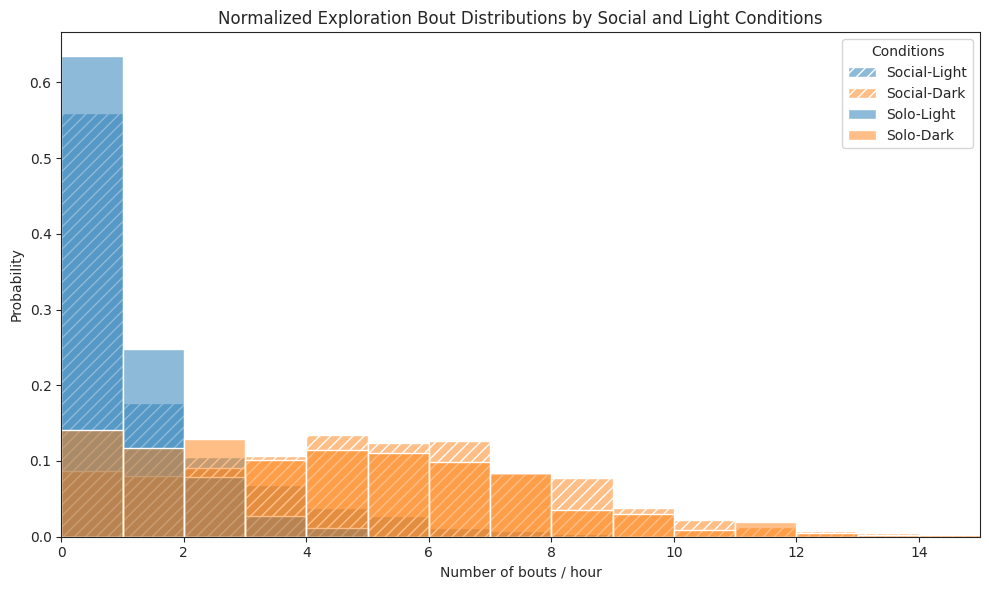

In [28]:
# Plot hist of bouts per hour
fig, ax = plt.subplots(figsize=(10, 6))
# Plot histograms for each combination
for i, (social_val, light_val) in enumerate(combos):
    subset = explore_hour_df[
        (explore_hour_df["social"] == social_val)
        & (explore_hour_df["light"] == light_val)
    ]
    # Plot normalized histogram
    hist = sns.histplot(
        data=subset,
        x="n_bouts",
        stat="probability",
        alpha=0.5,
        color=colors[light_val],
        label=labels[i],
        common_norm=False,  # Ensure each histogram is normalized separately
        axes=ax,
        binwidth=1,
    )
    # Set hatch pattern for bars
    if hatches[social_val]:
        for bar in hist.patches:
            bar.set_hatch(hatches[social_val])

ax.set_title("Normalized Exploration Bout Distributions by Social and Light Conditions")
ax.set_xlabel("Number of bouts / hour")
ax.set_ylabel("Probability")
ax.legend(title="Conditions")
ax.set_xticks(np.arange(0, 15, 2))
ax.set_xlim(0, 15)
plt.tight_layout()
plt.show()

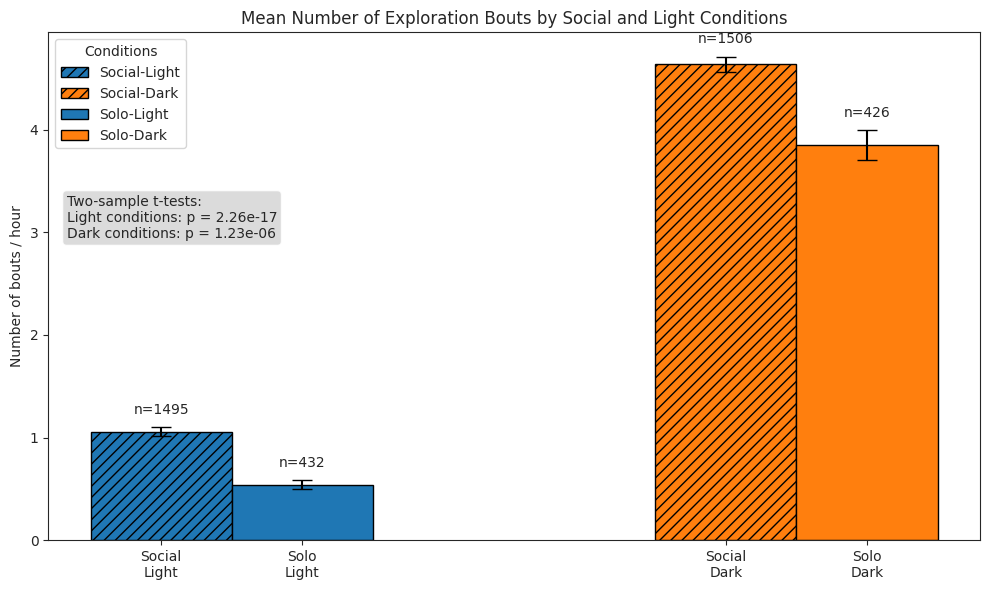

In [66]:
# Plot bars of bouts per hour
fig, ax = plt.subplots(figsize=(10, 6))
summary_data = []
for social_val in [True, False]:
    for light_val in [True, False]:
        subset = explore_hour_df[
            (explore_hour_df["social"] == social_val)
            & (explore_hour_df["light"] == light_val)
        ]
        mean_n_bouts = subset["n_bouts"].mean()
        sem_n_bouts = subset["n_bouts"].sem()
        n_samples = len(subset)
        summary_data.append(
            {
                "social": social_val,
                "light": light_val,
                "mean_n_bouts": mean_n_bouts,
                "sem": sem_n_bouts,
                "condition": f"{'Social' if social_val else 'Solo'}-{'Light' if light_val else 'Dark'}",
                "n": n_samples,
            }
        )

summary_df = pd.DataFrame(summary_data)
# Set up positions for the bars
bar_width = 0.5
x_pos = np.array([0.25, 2.25, 0.75, 2.75])  # create two groups with a gap in the middle
# Plot bars
for i, row in enumerate(summary_data):
    pos = x_pos[i]
    social_val = row["social"]
    light_val = row["light"]
    bar = ax.bar(
        pos,
        row["mean_n_bouts"],
        bar_width,
        yerr=row["sem"],
        color=colors[light_val],
        edgecolor="black",
        capsize=7,
        label=row["condition"],
    )
    # Apply hatching for social conditions
    if hatches[social_val]:
        bar[0].set_hatch(hatches[social_val])
    # Add sample size as text above each bar
    sample_size_txt = ax.text(
        pos,
        row["mean_n_bouts"] + row["sem"] + 0.1,
        f"n={row['n']}",
        ha="center",
        va="bottom",
    )

ax.set_title("Mean Number of Exploration Bouts by Social and Light Conditions")
ax.set_ylabel("Number of bouts / hour")
ax.set_xticks(x_pos)
ax.set_xticklabels(["Social\nLight", "Social\nDark", "Solo\nLight", "Solo\nDark"])
ax.legend(title="Conditions", loc="upper left")
# Perform Wilcoxon rank sum tests (Mann-Whitney U)
light_social = explore_hour_df.query("social and light")["n_bouts"]
light_solo   = explore_hour_df.query("not social and light")["n_bouts"]
dark_social  = explore_hour_df.query("social and not light")["n_bouts"]
dark_solo    = explore_hour_df.query("not social and not light")["n_bouts"]
light_stat, light_p = stats.ttest_ind(
    light_social, light_solo, alternative="two-sided", equal_var=False
)
dark_stat, dark_p = stats.ttest_ind(
    dark_social, dark_solo, alternative="two-sided", equal_var=False
)
test_text = (
    f"Two-sample t-tests:\n"
    f"Light conditions: p = {light_p:.2e}\nDark conditions: p = {dark_p:.2e}"
)
props = dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8)
ax.text(
    0.02,
    0.68,  # Position below the legend
    test_text,
    transform=ax.transAxes,
    verticalalignment="top",
    bbox=props,
)
plt.tight_layout()
plt.show()

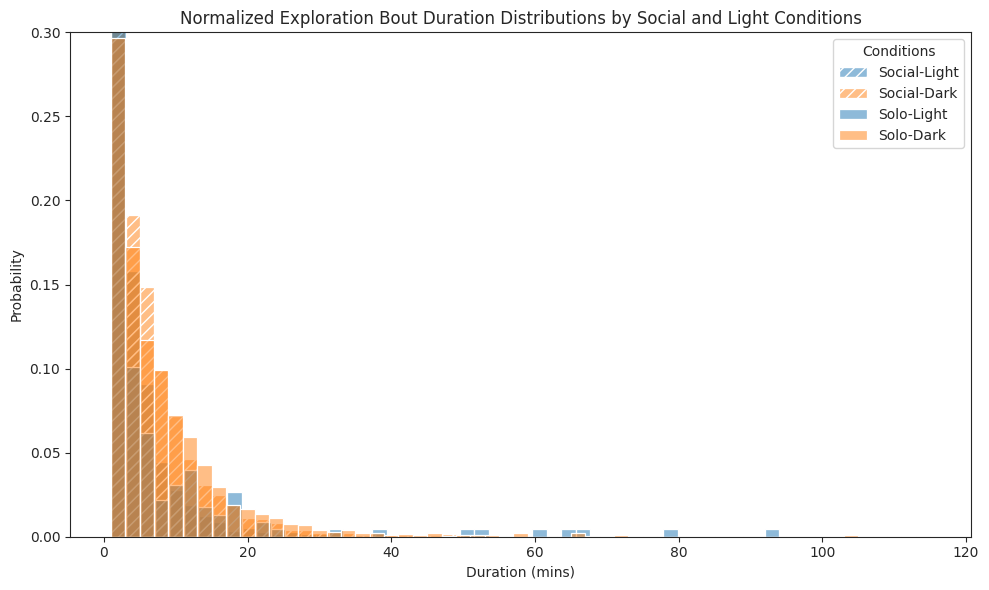

In [68]:
# Plot histograms of durations of bouts for each combination
fig, ax = plt.subplots(figsize=(10, 6))
for i, (social_val, light_val) in enumerate(combos):
    subset = explore_dur_df[
        (explore_dur_df["social"] == social_val)
        & (explore_dur_df["light"] == light_val)
    ]
    # Plot normalized histogram
    hist = sns.histplot(
        data=subset,
        x="duration",
        stat="probability",
        alpha=0.5,
        color=colors[light_val],
        label=labels[i],
        # kde=True,  # Add kernel density estimate
        common_norm=False,  # Ensure each histogram is normalized separately
        axes=ax,
        binwidth=2,
    )
    # Set hatch pattern for bars
    if hatches[social_val]:
        for bar in hist.patches:
            bar.set_hatch(hatches[social_val])

ax.set_title(
    "Normalized Exploration Bout Duration Distributions by Social and Light Conditions"
)
ax.set_xlabel("Duration (mins)")
ax.set_ylabel("Probability")
ax.legend(title="Conditions")
ax.set_ylim(0, 0.3)
plt.tight_layout()
plt.show()

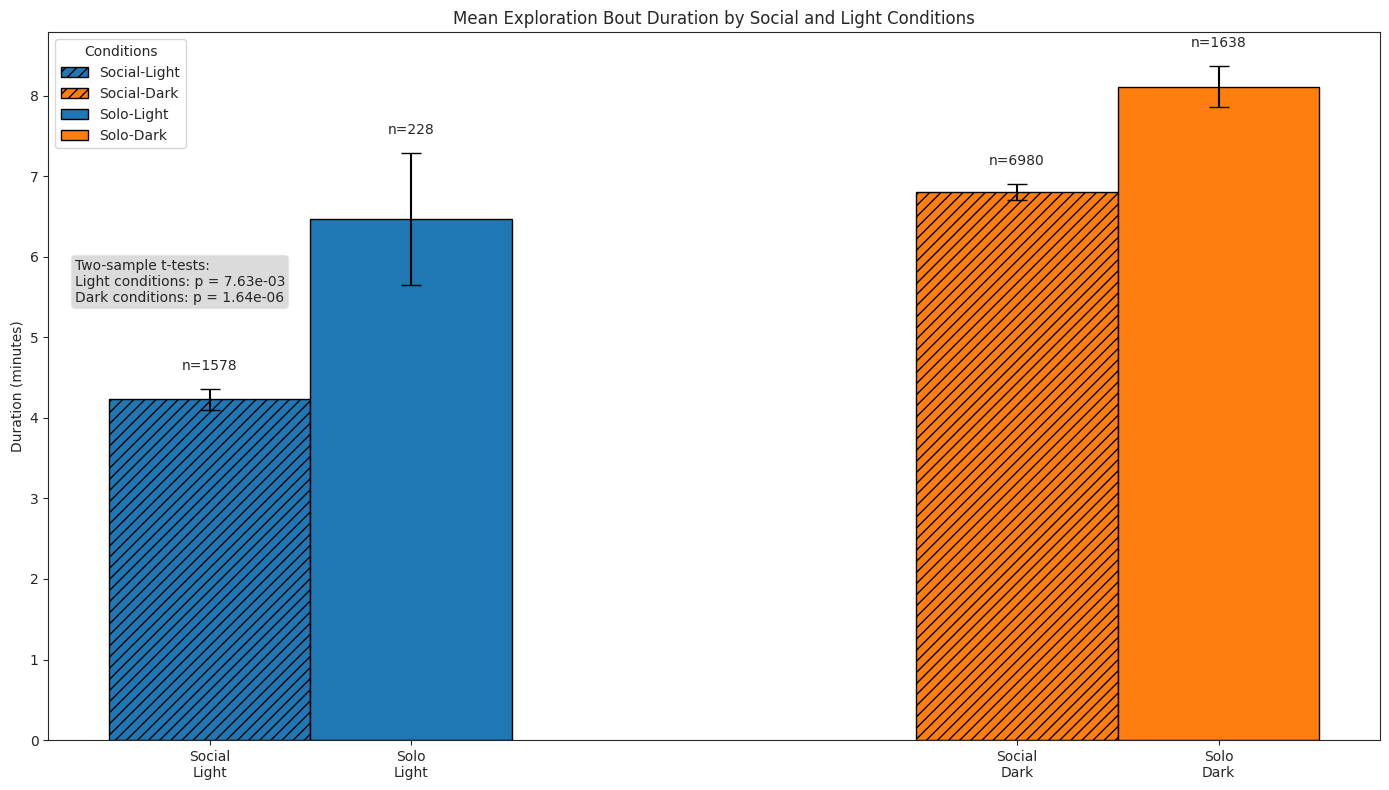

In [75]:
# Plot bars of durations of bouts
fig, ax = plt.subplots(figsize=(14, 8))
summary_data = []
for social_val in [True, False]:
    for light_val in [True, False]:
        subset = explore_dur_df[
            (explore_dur_df["social"] == social_val)
            & (explore_dur_df["light"] == light_val)
        ]
        mean_duration = subset["duration"].mean()
        sem_duration = subset["duration"].sem()
        n_samples = len(subset)
        summary_data.append(
            {
                "social": social_val,
                "light": light_val,
                "mean_duration": mean_duration,
                "sem": sem_duration,
                "condition": f"{'Social' if social_val else 'Solo'}-{'Light' if light_val else 'Dark'}",
                "n": n_samples,
            }
        )

summary_df = pd.DataFrame(summary_data)
# Set up positions for the bars
bar_width = 0.5
x_pos = np.array([0.25, 2.25, 0.75, 2.75])  # create two groups with a gap in the middle
# Plot bars
for i, row in enumerate(summary_data):
    pos = x_pos[i]
    social_val = row["social"]
    light_val = row["light"]
    bar = ax.bar(
        pos,
        row["mean_duration"],
        bar_width,
        yerr=row["sem"],
        color=colors[light_val],
        edgecolor="black",
        capsize=7,
        label=row["condition"],
    )
    # Apply hatching for social conditions
    if hatches[social_val]:
        bar[0].set_hatch(hatches[social_val])
    # Add sample size as text above each bar
    sample_size_txt = ax.text(
        pos,
        row["mean_duration"] + row["sem"] + 0.2,
        f"n={row['n']}",
        ha="center",
        va="bottom",
    )

ax.set_title("Mean Exploration Bout Duration by Social and Light Conditions")
ax.set_ylabel("Duration (minutes)")
ax.set_xticks(x_pos)
ax.set_xticklabels(["Social\nLight", "Social\nDark", "Solo\nLight", "Solo\nDark"])
ax.legend(title="Conditions", loc="upper left")
# Perform Wilcoxon rank sum tests (Mann-Whitney U)
light_social = explore_dur_df.query("social and light")["duration"]
light_solo   = explore_dur_df.query("not social and light")["duration"]
dark_social  = explore_dur_df.query("social and not light")["duration"]
dark_solo    = explore_dur_df.query("not social and not light")["duration"]
light_stat, light_p = stats.ttest_ind(
    light_social, light_solo, alternative="two-sided", equal_var=False
)
dark_stat, dark_p = stats.ttest_ind(
    dark_social, dark_solo, alternative="two-sided", equal_var=False
)
test_text = (
    f"Two-sample t-tests:\n"
    f"Light conditions: p = {light_p:.2e}\nDark conditions: p = {dark_p:.2e}"
)
props = dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8)
ax.text(
    0.02,
    0.68,  # Position below the legend
    test_text,
    transform=ax.transAxes,
    verticalalignment="top",
    bbox=props,
)
plt.tight_layout()
plt.show()

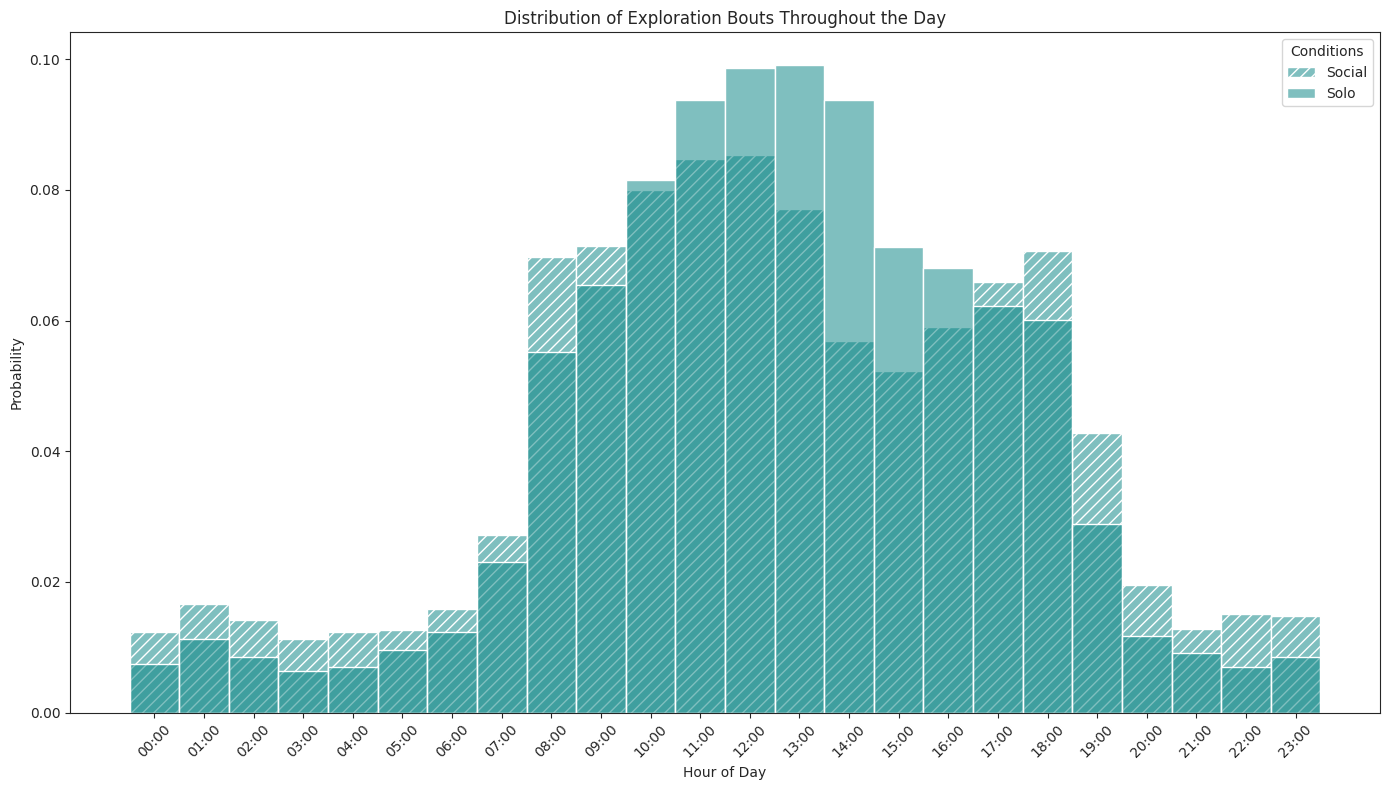

In [77]:
# Plot histograms of times of bouts over all hours
fig, ax = plt.subplots(figsize=(14, 8))
for i, social_val in enumerate([True, False]):
    subset = explore_dur_df[(explore_dur_df["social"] == social_val)]
    # Create the histogram
    hist = sns.histplot(
        data=subset,
        x=subset["start"].dt.hour,
        stat="probability",  # Normalize to show probability
        alpha=0.5,
        color="teal",
        label="Social" if social_val else "Solo",
        common_norm=False,  # Each condition normalized separately
        ax=ax,
        bins=24,  # 24 hours
        discrete=True,  # Since hours are discrete values
    )
    # Apply hatching pattern for social conditions
    if hatches[social_val]:
        # Apply the hatch pattern to each bar
        for patch in hist.patches:
            patch.set_hatch(hatches[social_val])

# Set x-tick labels for every hour
ax.set_xticks(range(0, 24))
ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 24)], rotation=45)
# Customize axis labels and title
ax.set_title("Distribution of Exploration Bouts Throughout the Day")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Probability")
ax.legend(title="Conditions")
plt.tight_layout()
plt.show()

### Foraging

We compare subjects' foraging behaviour in solo and social conditions across light and dark cycles, and show that subjects in the social condition engaged in more frequent but shorter foraging bouts, yielding a higher total pellet count than in the solo condition.

Notably, despite the increaed activity and pellet yield, the total distance spun on the foraging wheel was lower in the social condition, reflecting a shift towards more efficient foraging under social conditions.

In [92]:
# Final dfs:
# 1. forage_hour_df: hour, n_pellets, dist_forage, n_bouts, exp, social-bool, subject, light-bool
# 2. forage_dur_df: start, duration(mins), exp, social-bool, subject, light-bool
forage_hour_df = pd.DataFrame({
    "hour": pd.Series(dtype="datetime64[ns]"),
    "n_bouts": pd.Series(dtype="int"),
    "n_pellets": pd.Series(dtype="int"),
    "dist_forage": pd.Series(dtype="float"),
    "exp": pd.Series(dtype="string"),
    "social": pd.Series(dtype="bool"),
    "subject": pd.Series(dtype="string"),
    "light": pd.Series(dtype="bool"),
})
forage_dur_df = pd.DataFrame({
    "start": pd.Series(dtype="datetime64[ns]"),
    "duration": pd.Series(dtype="float"), # in minutes
    "exp": pd.Series(dtype="string"),
    "social": pd.Series(dtype="bool"),
    "subject": pd.Series(dtype="string"),
    "light": pd.Series(dtype="bool"),
})

In [ ]:
# For each period
# Load foraging data
# Split into individual dfs
# Calculate hour-by-hour metrics and put into final df
exp_pbar = tqdm(experiments, desc="Experiments", position=0, leave=True)
for exp in exp_pbar:
    period_pbar = tqdm(periods, desc="Periods", position=1, leave=False)
    for period in period_pbar:
        forage_df = load_data_from_parquet(
            experiment_name=exp["name"],
            period=period,
            data_type="foraging",
            data_dir=data_dir,
            set_time_index=True,
        )
        for subject in forage_df["subject"].unique():
            forage_df_subj = forage_df[forage_df["subject"] == subject]
            forage_df_subj["hour"] = forage_df_subj["start"].dt.floor("h")
            hour_counts = pd.merge(
                forage_df_subj.groupby("hour").size().reset_index(name="n_bouts"),
                forage_df_subj.groupby("hour").agg(
                    n_pellets=("n_pellets", "sum"),
                    cum_wheel_dist=("cum_wheel_dist", "sum"),
                ),
                on="hour",
                how="left",
            )
            min_hour, max_hour = (
                forage_df_subj["hour"].min(),
                forage_df_subj["hour"].max(),
            )
            complete_hours = pd.DataFrame(
                {"hour": pd.date_range(start=min_hour, end=max_hour, freq="h")}
            )
            forage_df_subj_hour = pd.merge(
                complete_hours, hour_counts, on="hour", how="left"
            ).fillna(0)
            forage_df_subj_hour["n_bouts"] = forage_df_subj_hour["n_bouts"].astype(int)
            # Rename 'cum_wheel_dist' col
            forage_df_subj_hour.rename(
                columns={"cum_wheel_dist": "dist_forage"}, inplace=True
            )
            forage_df_subj_hour["exp"] = exp["name"]
            forage_df_subj_hour["social"] = period == "social"
            forage_df_subj_hour["subject"] = subject
            hour = forage_df_subj_hour["hour"].dt.hour
            forage_df_subj_hour["light"] = ~((hour > light_off) & (hour < light_on))
            forage_hour_df = pd.concat(
                [forage_hour_df, forage_df_subj_hour], ignore_index=True
            )

            forage_dur_subj = forage_df_subj[["start"]].copy()
            forage_dur_subj["duration"] = (
                forage_df_subj["end"] - forage_df_subj["start"]
            ).dt.total_seconds() / 60
            forage_dur_subj["exp"] = exp["name"]
            forage_dur_subj["social"] = period == "social"
            forage_dur_subj["subject"] = subject
            hour = forage_df_subj["start"].dt.hour
            forage_dur_subj["light"] = ~((hour > light_off) & (hour < light_on))
            forage_dur_df = pd.concat(
                [forage_dur_df, forage_dur_subj], ignore_index=True
            )

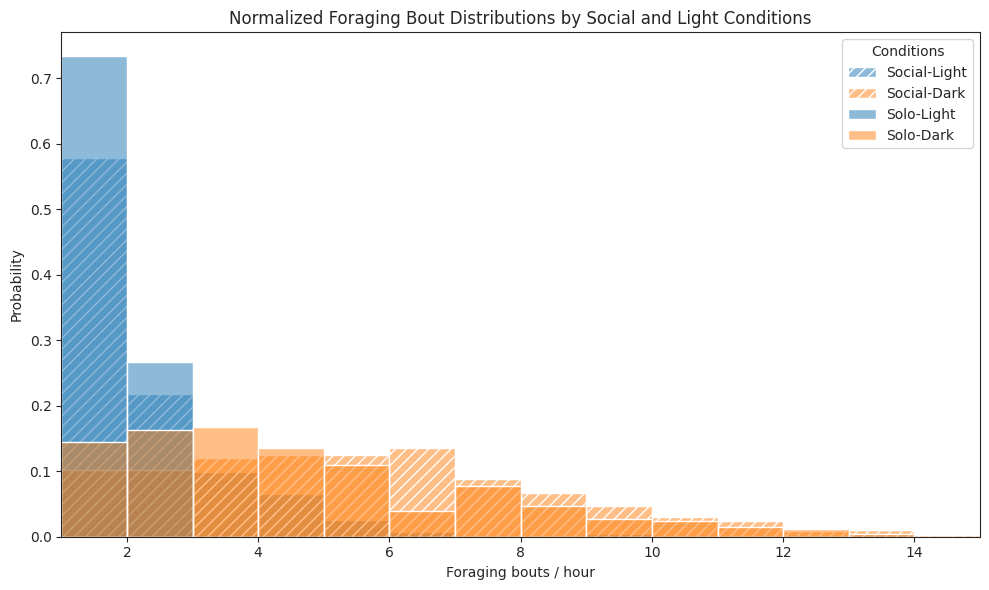

In [94]:
# Plot foraging bouts per hour histogram for each combination
fig, ax = plt.subplots(figsize=(10, 6))
for i, (social_val, light_val) in enumerate(combos):
    subset = forage_hour_df[
        (forage_hour_df["social"] == social_val)
        & (forage_hour_df["light"] == light_val)
        & (forage_hour_df["n_pellets"] > 0)
    ]
    # Plot normalized histogram
    hist = sns.histplot(
        data=subset,
        x="n_bouts",
        stat="probability",
        alpha=0.5,
        color=colors[light_val],
        label=labels[i],
        # kde=True,  # Add kernel density estimate
        common_norm=False,  # Ensure each histogram is normalized separately
        axes=ax,
        binwidth=1,
    )
    # Set hatch pattern for bars
    if hatches[social_val]:
        for bar in hist.patches:
            bar.set_hatch(hatches[social_val])

ax.set_title("Normalized Foraging Bout Distributions by Social and Light Conditions")
ax.set_xlabel("Foraging bouts / hour")
ax.set_ylabel("Probability")
ax.legend(title="Conditions")
ax.set_xlim(1, 15)
plt.tight_layout()
plt.show()

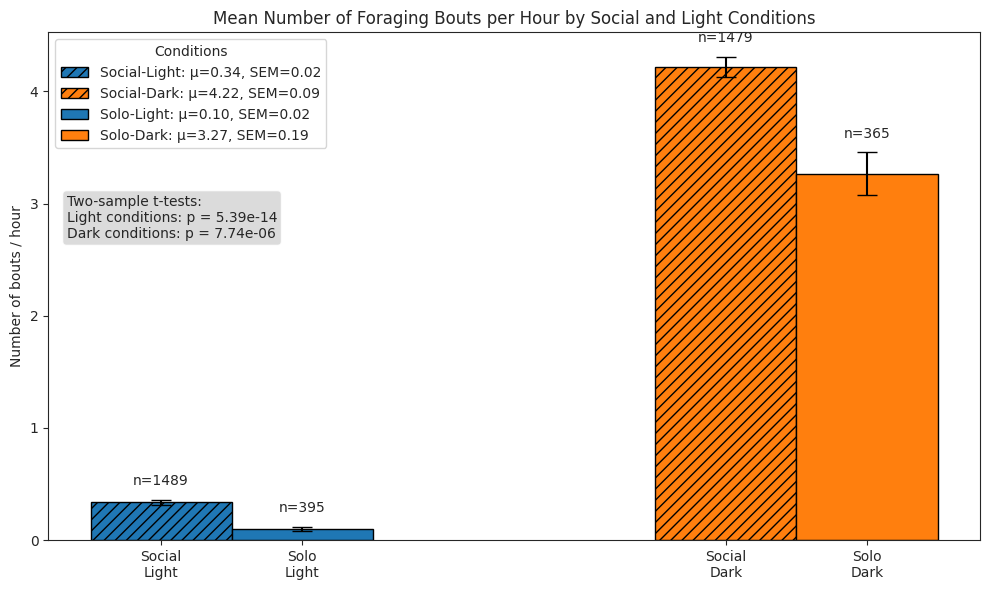

In [86]:
# Plot foraging bouts per hour bars
fig, ax = plt.subplots(figsize=(10, 6))
summary_data = []
for social_val in [True, False]:
    for light_val in [True, False]:
        subset = forage_hour_df[
            (forage_hour_df["social"] == social_val)
            & (forage_hour_df["light"] == light_val)
        ]
        mean_n_bouts = subset["n_bouts"].mean()
        sem_n_bouts = subset["n_bouts"].sem()
        n_samples = len(subset)
        summary_data.append(
            {
                "social": social_val,
                "light": light_val,
                "mean_n_bouts": mean_n_bouts,
                "sem": sem_n_bouts,
                "condition": f"{'Social' if social_val else 'Solo'}-{'Light' if light_val else 'Dark'}",
                "n": n_samples,
            }
        )

summary_df = pd.DataFrame(summary_data)
# Set up positions for the bars
bar_width = 0.5
x_pos = np.array([0.25, 2.25, 0.75, 2.75])  # create two groups with a gap in the middle
# Plot bars
for i, row in enumerate(summary_data):
    pos = x_pos[i]
    social_val = row["social"]
    light_val = row["light"]
    bar = ax.bar(
        pos,
        row["mean_n_bouts"],
        bar_width,
        yerr=row["sem"],
        color=colors[light_val],
        edgecolor="black",
        capsize=7,
        label=f"{row['condition']}: μ={row['mean_n_bouts']:.2f}, SEM={row['sem']:.2f}",
    )
    # Apply hatching for social conditions
    if hatches[social_val]:
        bar[0].set_hatch(hatches[social_val])
    # Add sample size as text above each bar
    sample_size_txt = ax.text(
        pos,
        row["mean_n_bouts"] + row["sem"] + 0.1,
        f"n={row['n']}",
        ha="center",
        va="bottom",
    )

ax.set_title("Mean Number of Foraging Bouts per Hour by Social and Light Conditions")
ax.set_ylabel("Number of bouts / hour")
ax.set_xticks(x_pos)
ax.set_xticklabels(["Social\nLight", "Social\nDark", "Solo\nLight", "Solo\nDark"])
ax.legend(title="Conditions", loc="upper left")
# Wilcoxon rank sum tests
light_social = forage_hour_df.query("social and light")["n_bouts"]
light_solo   = forage_hour_df.query("not social and light")["n_bouts"]
dark_social  = forage_hour_df.query("social and not light")["n_bouts"]
dark_solo    = forage_hour_df.query("not social and not light")["n_bouts"]
light_stat, light_p = stats.ttest_ind(
    light_social, light_solo, alternative="two-sided", equal_var=False
)
dark_stat, dark_p = stats.ttest_ind(
    dark_social, dark_solo, alternative="two-sided", equal_var=False
)
test_text = (
    f"Two-sample t-tests:\n"
    f"Light conditions: p = {light_p:.2e}\nDark conditions: p = {dark_p:.2e}"
)
props = dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8)
ax.text(
    0.02,
    0.68,
    test_text,
    transform=ax.transAxes,
    verticalalignment="top",
    bbox=props,
)
plt.tight_layout()
plt.show()

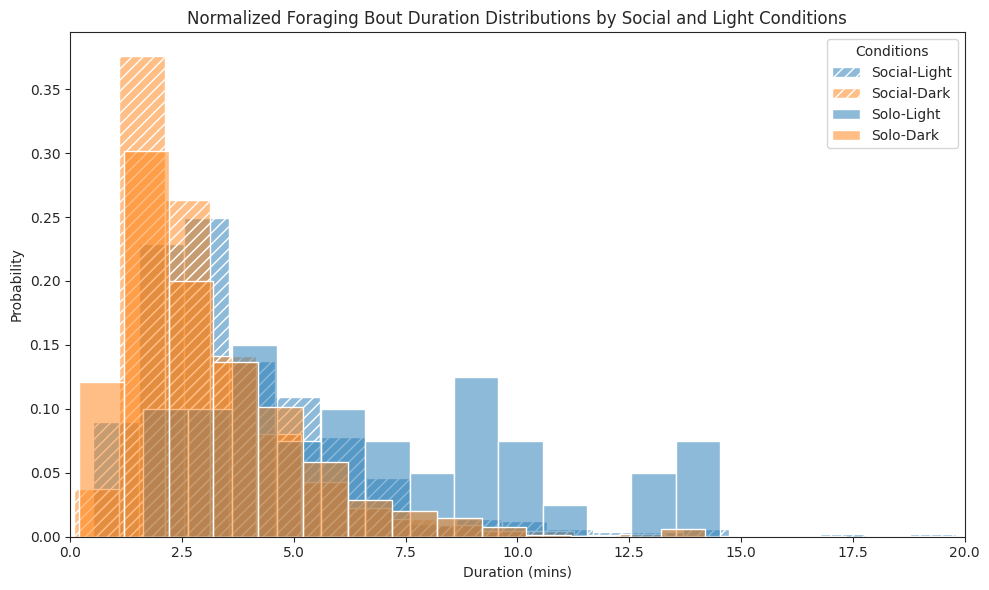

In [95]:
# Plot foraging bouts duration histogram for each combination
fig, ax = plt.subplots(figsize=(10, 6))
for i, (social_val, light_val) in enumerate(combos):
    subset = forage_dur_df[
        (forage_dur_df["social"] == social_val) & (forage_dur_df["light"] == light_val)
    ]
    # Plot normalized histogram
    hist = sns.histplot(
        data=subset,
        x="duration",
        stat="probability",
        alpha=0.5,
        color=colors[light_val],
        label=labels[i],
        # kde=True,  # Add kernel density estimate
        common_norm=False,  # Ensure each histogram is normalized separately
        axes=ax,
        binwidth=1,
    )
    # Set hatch pattern for bars
    if hatches[social_val]:
        for bar in hist.patches:
            bar.set_hatch(hatches[social_val])

ax.set_title(
    "Normalized Foraging Bout Duration Distributions by Social and Light Conditions"
)
ax.set_xlabel("Duration (mins)")
ax.set_ylabel("Probability")
ax.legend(title="Conditions")
ax.set_xlim(0, 20)
plt.tight_layout()
plt.show()

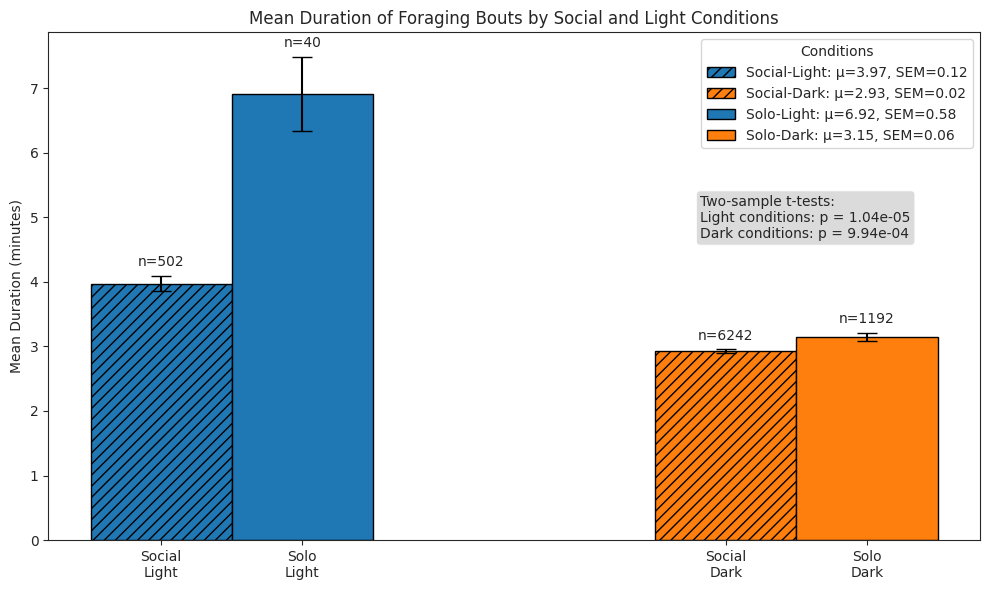

In [101]:
# Plot foraging bouts duration bars
max_forage_thresh = 30  # in minutes
fig, ax = plt.subplots(figsize=(10, 6))
summary_data = []
for social_val in [True, False]:
    for light_val in [True, False]:
        subset = forage_dur_df[
            (forage_dur_df["social"] == social_val)
            & (forage_dur_df["light"] == light_val)
            & (forage_dur_df["duration"] < max_forage_thresh)
        ]
        mean_duration = subset["duration"].mean()
        sem_duration = subset["duration"].sem()
        n_samples = len(subset)
        summary_data.append(
            {
                "social": social_val,
                "light": light_val,
                "mean_duration": mean_duration,
                "sem": sem_duration,
                "condition": f"{'Social' if social_val else 'Solo'}-{'Light' if light_val else 'Dark'}",
                "n": n_samples,
            }
        )

summary_df = pd.DataFrame(summary_data)
# Set up positions for the bars
bar_width = 0.5
x_pos = np.array([0.25, 2.25, 0.75, 2.75])  # create two groups with a gap in the middle
# Plot bars
for i, row in enumerate(summary_data):
    pos = x_pos[i]
    social_val = row["social"]
    light_val = row["light"]
    bar = ax.bar(
        pos,
        row["mean_duration"],
        bar_width,
        yerr=row["sem"],
        color=colors[light_val],
        edgecolor="black",
        capsize=7,
        label=f"{row['condition']}: μ={row['mean_duration']:.2f}, SEM={row['sem']:.2f}",
    )
    # Apply hatching for social conditions
    if hatches[social_val]:
        bar[0].set_hatch(hatches[social_val])
    # Add sample size as text above each bar
    sample_size_txt = ax.text(
        pos,
        row["mean_duration"] + row["sem"] + 0.1,
        f"n={row['n']}",
        ha="center",
        va="bottom",
    )

ax.set_title("Mean Duration of Foraging Bouts by Social and Light Conditions")
ax.set_ylabel("Mean Duration (minutes)")
ax.set_xticks(x_pos)
ax.set_xticklabels(["Social\nLight", "Social\nDark", "Solo\nLight", "Solo\nDark"])
ax.legend(title="Conditions", loc="upper right")
# Wilcoxon rank sum tests
light_social = forage_dur_df.query("social and light and duration < @max_forage_thresh")["duration"]
light_solo   = forage_dur_df.query("not social and light and duration < @max_forage_thresh")["duration"]
dark_social  = forage_dur_df.query("social and not light and duration < @max_forage_thresh")["duration"]
dark_solo    = forage_dur_df.query("not social and not light and duration < @max_forage_thresh")["duration"]

# light_social = forage_dur_df[
#     (forage_dur_df["social"] == True)
#     & (forage_dur_df["light"] == True)
#     & (forage_dur_df["duration"] < max_forage_thresh)
# ]["duration"]
# light_solo = forage_dur_df[
#     (forage_dur_df["social"] == False)
#     & (forage_dur_df["light"] == True)
#     & (forage_dur_df["duration"] < max_forage_thresh)
# ]["duration"]
# dark_social = forage_dur_df[
#     (forage_dur_df["social"] == True)
#     & (forage_dur_df["light"] == False)
#     & (forage_dur_df["duration"] < max_forage_thresh)
# ]["duration"]
# dark_solo = forage_dur_df[
#     (forage_dur_df["social"] == False)
#     & (forage_dur_df["light"] == False)
#     & (forage_dur_df["duration"] < max_forage_thresh)
# ]["duration"]

# light_social = pd.to_numeric(light_social, errors="coerce").dropna()
# light_solo = pd.to_numeric(light_solo, errors="coerce").dropna()
# dark_social = pd.to_numeric(dark_social, errors="coerce").dropna()
# dark_solo = pd.to_numeric(dark_solo, errors="coerce").dropna()

light_stat, light_p = stats.ttest_ind(
    light_social, light_solo, alternative="two-sided", equal_var=False
)
dark_stat, dark_p = stats.ttest_ind(
    dark_social, dark_solo, alternative="two-sided", equal_var=False
)

test_text = (
    f"Two-sample t-tests:\n"
    f"Light conditions: p = {light_p:.2e}\nDark conditions: p = {dark_p:.2e}"
)
props = dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8)
ax.text(
    0.70,
    0.68,
    test_text,
    transform=ax.transAxes,
    verticalalignment="top",
    bbox=props,
)
plt.tight_layout()
plt.show()

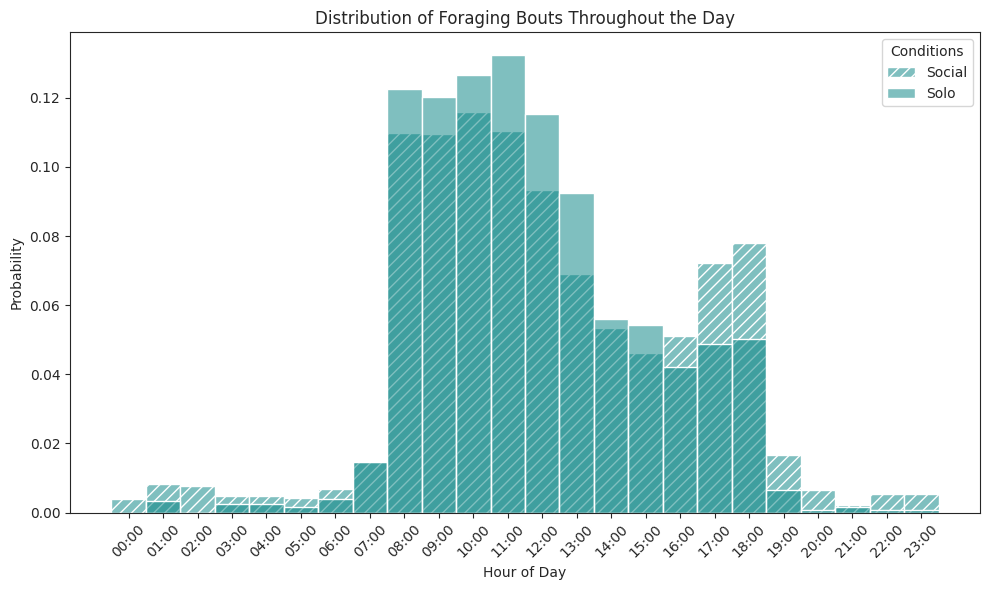

In [103]:
# Plot foraging bouts over all hours histogram
fig, ax = plt.subplots(figsize=(10, 6))
for i, social_val in enumerate([True, False]):
    subset = forage_dur_df[(forage_dur_df["social"] == social_val)]
    # Create the histogram
    hist = sns.histplot(
        data=subset,
        x=subset["start"].dt.hour,
        stat="probability",  # Normalize to show probability
        alpha=0.5,
        color="teal",
        label="Social" if social_val else "Solo",
        common_norm=False,  # Each condition normalized separately
        ax=ax,
        bins=24,  # 24 hours
        discrete=True,  # Since hours are discrete values
    )
    # Apply hatching pattern for social conditions
    if hatches[social_val]:
        # Apply the hatch pattern to each bar
        for patch in hist.patches:
            patch.set_hatch(hatches[social_val])

# Set x-tick labels for every hour
ax.set_xticks(range(0, 24))
ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 24)], rotation=45)
# Customize axis labels and title
ax.set_title("Distribution of Foraging Bouts Throughout the Day")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Probability")
ax.legend(title="Conditions")
plt.tight_layout()
plt.show()

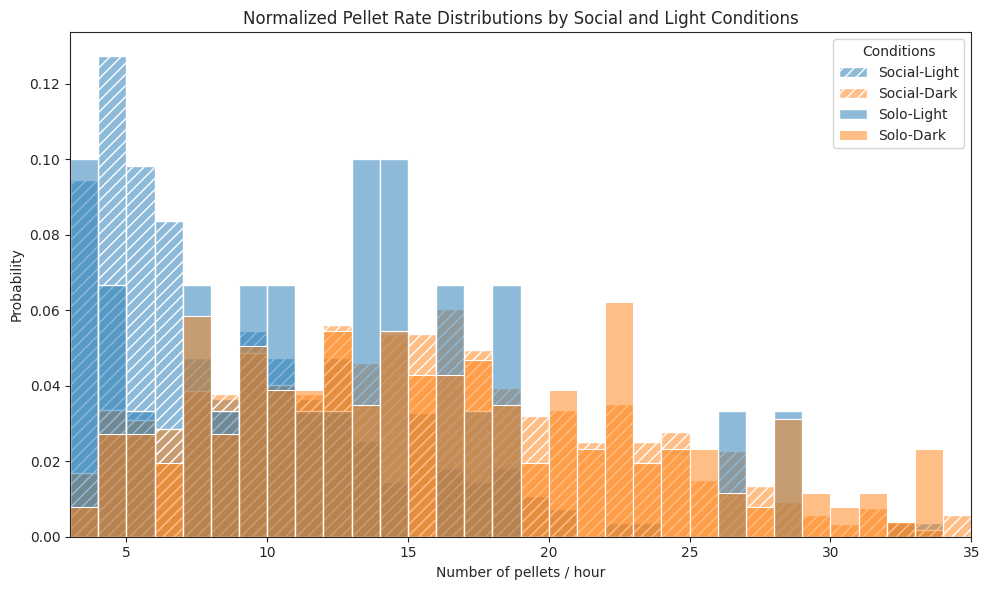

In [106]:
# Plot pellet rate per hour histograms for each combination
fig, ax = plt.subplots(figsize=(10, 6))
for i, (social_val, light_val) in enumerate(combos):
    subset = forage_hour_df[
        (forage_hour_df["social"] == social_val)
        & (forage_hour_df["light"] == light_val)
        & (forage_hour_df["n_pellets"] > 0)
    ]
    # Plot normalized histogram
    hist = sns.histplot(
        data=subset,
        x="n_pellets",
        stat="probability",
        alpha=0.5,
        color=colors[light_val],
        label=labels[i],
        # kde=True,  # Add kernel density estimate
        common_norm=False,  # Ensure each histogram is normalized separately
        axes=ax,
        binwidth=1,
    )
    # Set hatch pattern for bars
    if hatches[social_val]:
        for bar in hist.patches:
            bar.set_hatch(hatches[social_val])

ax.set_title("Normalized Pellet Rate Distributions by Social and Light Conditions")
ax.set_xlabel("Number of pellets / hour")
ax.set_ylabel("Probability")
ax.legend(title="Conditions")
ax.set_xlim(3, 35)
plt.tight_layout()
plt.show()

Plotting Social-Light: mean=1.13, sem=0.08, n=1801
Plotting Social-Dark: mean=11.53, sem=0.22, n=1804
Plotting Solo-Light: mean=0.83, sem=0.15, n=491
Plotting Solo-Dark: mean=12.33, sem=0.54, n=467


Text(0.02, 0.68, 'Two-sample t-tests:\nLight conditions: p = 8.50e-02\nDark conditions: p = 1.70e-01')

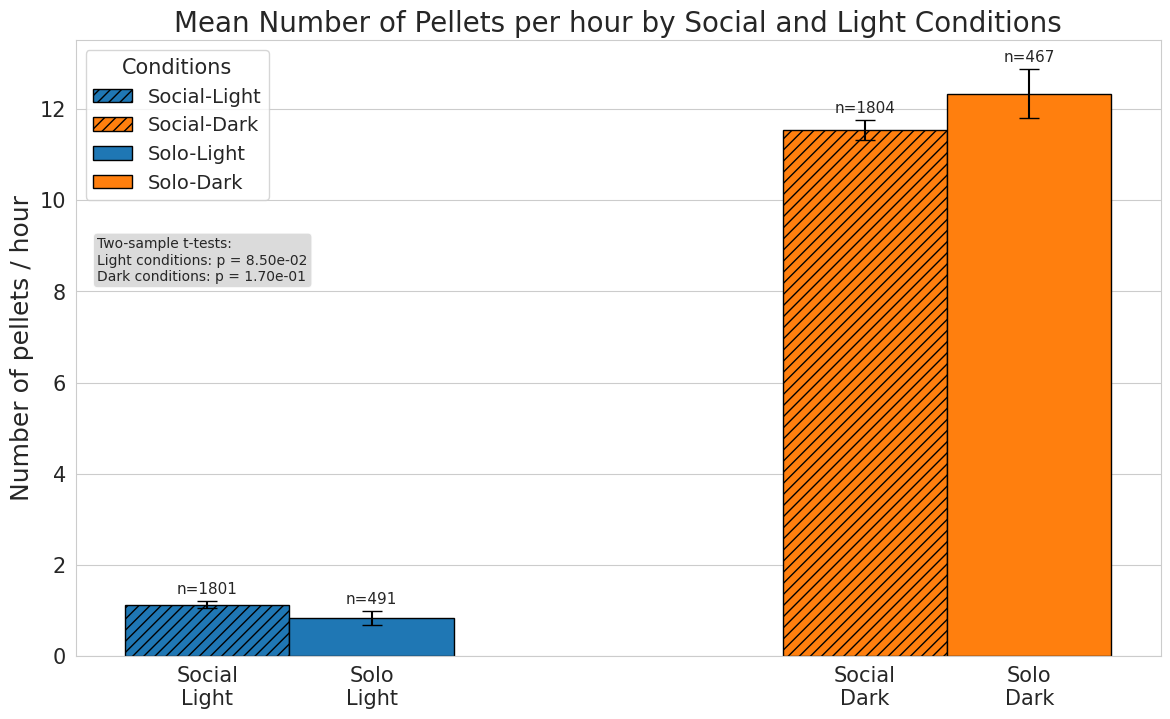

In [28]:
"""Pellet rate per hour bars."""

fig, ax = plt.subplots(figsize=(14, 8))

summary_data = []
for social_val in [True, False]:
    for light_val in [True, False]:
        subset = forage_hour_df[
            (forage_hour_df["social"] == social_val)
            & (forage_hour_df["light"] == light_val)
        ]
        mean_n_pellets = subset["n_pellets"].mean()
        sem_n_pellets = subset["n_pellets"].sem()
        n_samples = len(subset)
        summary_data.append(
            {
                "social": social_val,
                "light": light_val,
                "mean_n_pellets": mean_n_pellets,
                "sem": sem_n_pellets,
                "condition": f"{'Social' if social_val else 'Solo'}-{'Light' if light_val else 'Dark'}",
                "n": n_samples,
            }
        )
summary_df = pd.DataFrame(summary_data)

# Set up positions for the bars
bar_width = 0.5
x_pos = np.array([0.25, 2.25, 0.75, 2.75])  # create two groups with a gap in the middle

# Plot bars
for i, row in enumerate(summary_data):
    pos = x_pos[i]
    social_val = row["social"]
    light_val = row["light"]

    bar = ax.bar(
        pos,
        row["mean_n_pellets"],
        bar_width,
        yerr=row["sem"],
        color=colors[light_val],
        edgecolor="black",
        capsize=7,
        label=row["condition"],
    )

    print(
        f"Plotting {row['condition']}: μ={row['mean_n_pellets']:.2f}, SEM={row['sem']:.2f}, n={row['n']}"
    )

    # Apply hatching for social conditions
    if hatches[social_val]:
        bar[0].set_hatch(hatches[social_val])

    # Add sample size as text above each bar
    sample_size_txt = ax.text(
        pos,
        row["mean_n_pellets"] + row["sem"] + 0.1,
        f"n={row['n']}",
        ha="center",
        va="bottom",
    )
    sample_size_txt.set_fontsize(11)

ax.set_title("Mean Number of Pellets per hour by Social and Light Conditions")
ax.set_ylabel("Number of pellets / hour")
ax.set_xticks(x_pos)
ax.set_xticklabels(["Social\nLight", "Social\nDark", "Solo\nLight", "Solo\nDark"])
ax.legend(title="Conditions", loc="upper left")


light_social = forage_hour_df[
    (forage_hour_df["social"] == True) & (forage_hour_df["light"] == True)
]["n_pellets"]
light_solo = forage_hour_df[
    (forage_hour_df["social"] == False) & (forage_hour_df["light"] == True)
]["n_pellets"]

dark_social = forage_hour_df[
    (forage_hour_df["social"] == True) & (forage_hour_df["light"] == False)
]["n_pellets"]
dark_solo = forage_hour_df[
    (forage_hour_df["social"] == False) & (forage_hour_df["light"] == False)
]["n_pellets"]

light_social = pd.to_numeric(light_social, errors="coerce").dropna()
light_solo = pd.to_numeric(light_solo, errors="coerce").dropna()
dark_social = pd.to_numeric(dark_social, errors="coerce").dropna()
dark_solo = pd.to_numeric(dark_solo, errors="coerce").dropna()

light_stat, light_p = stats.ttest_ind(
    light_social, light_solo, alternative="two-sided", equal_var=False
)
dark_stat, dark_p = stats.ttest_ind(
    dark_social, dark_solo, alternative="two-sided", equal_var=False
)

test_text = (
    f"Two-sample t-tests:\n"
    f"Light conditions: p = {light_p:.2e}\nDark conditions: p = {dark_p:.2e}"
)
props = dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8)
ax.text(
    0.02,
    0.68,  # Position below the legend (since legend is upper left)
    test_text,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=props,
)

(0.0, 15000.0)

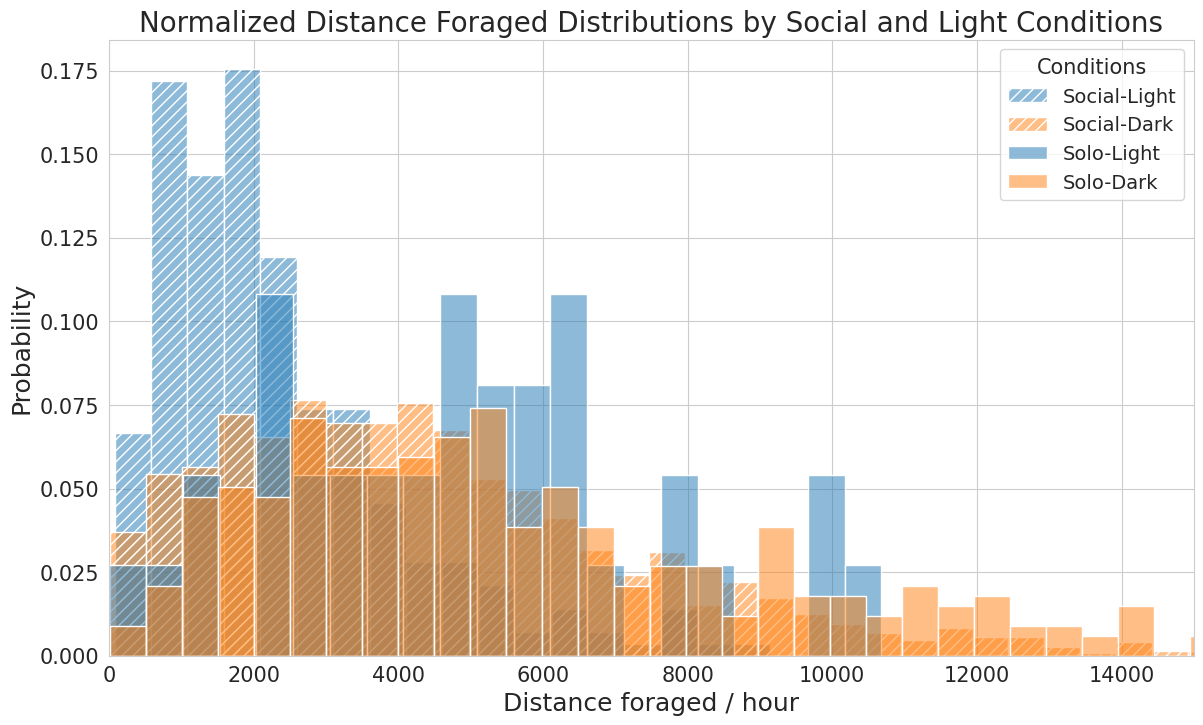

In [29]:
"""Distance foraged rate per hour histogram."""

fig, ax = plt.subplots(figsize=(14, 8))

# Plot histograms for each combination
for i, (social_val, light_val) in enumerate(combos):
    subset = forage_hour_df[
        (forage_hour_df["social"] == social_val)
        & (forage_hour_df["light"] == light_val)
        & (forage_hour_df["n_pellets"] > 0)
    ]
    # Plot normalized histogram
    hist = sns.histplot(
        data=subset,
        x="dist_forage",
        stat="probability",
        alpha=0.5,
        color=colors[light_val],
        label=labels[i],
        # kde=True,  # Add kernel density estimate
        common_norm=False,  # Ensure each histogram is normalized separately
        axes=ax,
        binwidth=500,
    )

    # Set hatch pattern for bars
    if hatches[social_val]:
        for bar in hist.patches:
            bar.set_hatch(hatches[social_val])

ax.set_title("Normalized Distance Foraged Distributions by Social and Light Conditions")
ax.set_xlabel("Distance foraged / hour")
ax.set_ylabel("Probability")
ax.legend(title="Conditions")

ax.set_xlim(0, 15000)

Plotting Social-Light: mean=371.06, sem=25.59, n=1801
Plotting Social-Dark: mean=3642.21, sem=78.83, n=1804
Plotting Solo-Light: mean=369.63, sem=66.23, n=491
Plotting Solo-Dark: mean=4552.04, sem=229.82, n=467


Text(0.02, 0.68, 'Two-sample t-tests:\nLight conditions: p = 9.84e-01\nDark conditions: p = 1.99e-04')

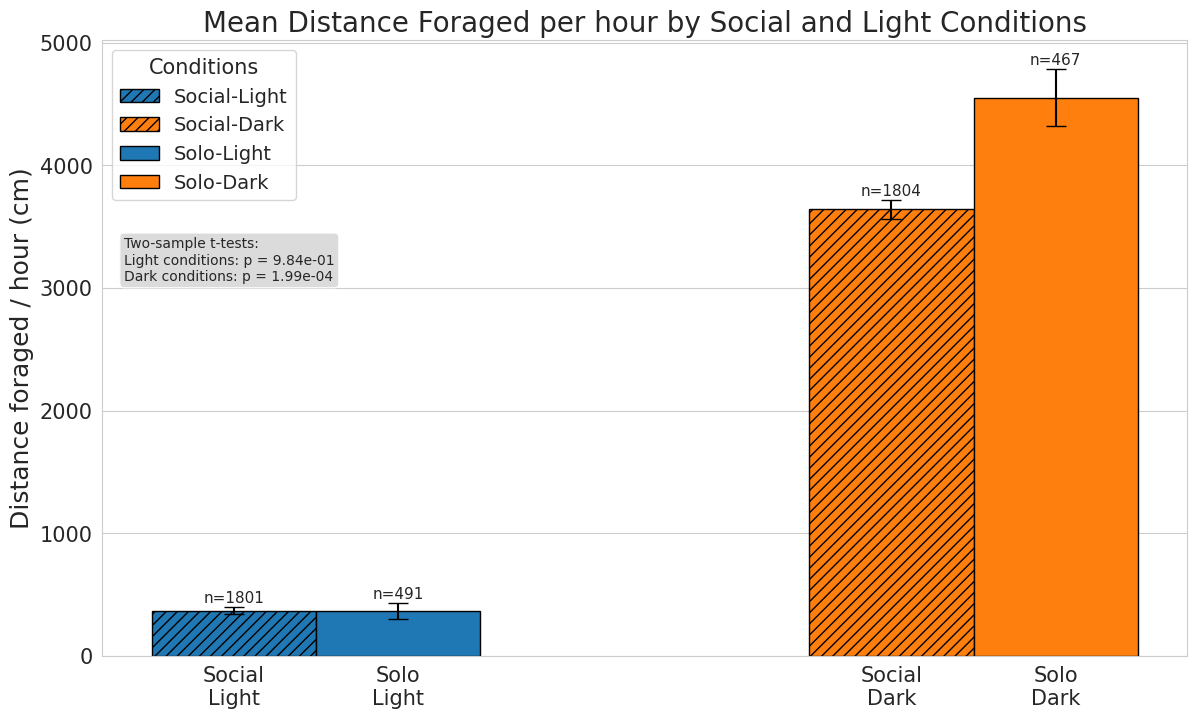

In [30]:
"""Distance foraged rate per hour bars."""

fig, ax = plt.subplots(figsize=(14, 8))

summary_data = []
for social_val in [True, False]:
    for light_val in [True, False]:
        subset = forage_hour_df[
            (forage_hour_df["social"] == social_val)
            & (forage_hour_df["light"] == light_val)
        ]
        mean_dist_forage = subset["dist_forage"].mean()
        sem_dist_forage = subset["dist_forage"].sem()
        n_samples = len(subset)
        summary_data.append(
            {
                "social": social_val,
                "light": light_val,
                "mean_dist_forage": mean_dist_forage,
                "sem": sem_dist_forage,
                "condition": f"{'Social' if social_val else 'Solo'}-{'Light' if light_val else 'Dark'}",
                "n": n_samples,
            }
        )
summary_df = pd.DataFrame(summary_data)

# Set up positions for the bars
bar_width = 0.5
x_pos = np.array([0.25, 2.25, 0.75, 2.75])  # create two groups with a gap in the middle

# Plot bars
for i, row in enumerate(summary_data):
    pos = x_pos[i]
    social_val = row["social"]
    light_val = row["light"]

    bar = ax.bar(
        pos,
        row["mean_dist_forage"],
        bar_width,
        yerr=row["sem"],
        color=colors[light_val],
        edgecolor="black",
        capsize=7,
        label=row["condition"],
    )

    print(
        f"Plotting {row['condition']}: μ={row['mean_dist_forage']:.2f}, SEM={row['sem']:.2f}, n={row['n']}"
    )

    # Apply hatching for social conditions
    if hatches[social_val]:
        bar[0].set_hatch(hatches[social_val])

    # Add sample size as text above each bar
    sample_size_txt = ax.text(
        pos,
        row["mean_dist_forage"] + row["sem"] + 10,
        f"n={row['n']}",
        ha="center",
        va="bottom",
    )
    sample_size_txt.set_fontsize(11)

ax.set_title("Mean Distance Foraged per hour by Social and Light Conditions")
ax.set_ylabel("Distance foraged / hour (cm)")
ax.set_xticks(x_pos)
ax.set_xticklabels(["Social\nLight", "Social\nDark", "Solo\nLight", "Solo\nDark"])
ax.legend(title="Conditions", loc="upper left")
light_social = forage_hour_df[
    (forage_hour_df["social"] == True) & (forage_hour_df["light"] == True)
]["dist_forage"]
light_solo = forage_hour_df[
    (forage_hour_df["social"] == False) & (forage_hour_df["light"] == True)
]["dist_forage"]

dark_social = forage_hour_df[
    (forage_hour_df["social"] == True) & (forage_hour_df["light"] == False)
]["dist_forage"]
dark_solo = forage_hour_df[
    (forage_hour_df["social"] == False) & (forage_hour_df["light"] == False)
]["dist_forage"]

# Wilcoxon rank sum tests

light_social = pd.to_numeric(light_social, errors="coerce").dropna()
light_solo = pd.to_numeric(light_solo, errors="coerce").dropna()
dark_social = pd.to_numeric(dark_social, errors="coerce").dropna()
dark_solo = pd.to_numeric(dark_solo, errors="coerce").dropna()

light_stat, light_p = stats.ttest_ind(
    light_social, light_solo, alternative="two-sided", equal_var=False
)
dark_stat, dark_p = stats.ttest_ind(
    dark_social, dark_solo, alternative="two-sided", equal_var=False
)

test_text = (
    f"Two-sample t-tests:\n"
    f"Light conditions: p = {light_p:.2e}\nDark conditions: p = {dark_p:.2e}"
)
props = dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8)
ax.text(
    0.02,
    0.68,  # Position below the legend (since legend is upper left)
    test_text,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=props,
)

### Sleeping

- n_bouts / hour
- duration of bouts
- total time spent sleeping / hour

In [ ]:
sleep_dur_df = pd.DataFrame(
    columns=["subject", "start", "end", "duration", "period", "light"]
)
sleep_hour_df = pd.DataFrame(
    columns=["subject", "hour", "n_bouts", "duration", "period", "light"]
)

exp_pbar = tqdm(experiments, desc="Experiments", position=0, leave=True)
for exp in exp_pbar:
    period_pbar = tqdm(periods, desc="Periods", position=1, leave=False)
    for period in period_pbar:
        sleep_bouts_df = load_data_from_parquet(
            experiment_name=exp["name"],
            period=period,
            data_type="sleep",
            data_dir=data_dir,
            set_time_index=True,
        )

        # Get sleep bout durations
        hour = sleep_bouts_df["start"].dt.hour
        sleep_bouts_df["light"] = ~((hour > light_off) & (hour < light_on))
        sleep_dur_df = pd.concat([sleep_dur_df, sleep_bouts_df], ignore_index=True)

        # Get n sleep bouts and total duration per hour
        for subject in sleep_bouts_df["subject"].unique():
            sleep_df_subj = sleep_bouts_df[sleep_bouts_df["subject"] == subject]
            sleep_df_subj["hour"] = sleep_df_subj["start"].dt.floor("h")
            hour_stats = (
                sleep_df_subj.groupby("hour")
                .agg({"duration": ["count", "sum"]})
                .reset_index()
            )
            hour_stats.columns = ["hour", "n_bouts", "duration"]

            min_hour, max_hour = (
                sleep_df_subj["hour"].min(),
                sleep_df_subj["hour"].max(),
            )
            complete_hours = pd.DataFrame(
                {"hour": pd.date_range(start=min_hour, end=max_hour, freq="h")}
            )
            sleep_df_subj_hour = pd.merge(
                complete_hours, hour_stats, on="hour", how="left"
            ).fillna(0)
            sleep_df_subj_hour["n_bouts"] = sleep_df_subj_hour["n_bouts"].astype(int)
            sleep_df_subj_hour["period"] = period
            sleep_df_subj_hour["subject"] = subject
            hour = sleep_df_subj_hour["hour"].dt.hour
            sleep_df_subj_hour["light"] = ~((hour > light_off) & (hour < light_on))
            sleep_hour_df = pd.concat(
                [sleep_hour_df, sleep_df_subj_hour], ignore_index=True
            )

sleep_dur_df["duration"] = (
    pd.to_timedelta(sleep_dur_df["duration"]).dt.total_seconds() / 60
)
sleep_hour_df["duration"] = (
    pd.to_timedelta(sleep_hour_df["duration"]).dt.total_seconds() / 60
)

Plotting Social-Light: mean=3.44, sem=0.05, n=1834
Plotting Social-Dark: mean=2.06, sem=0.05, n=1815
Plotting Solo-Light: mean=1.04, sem=0.05, n=528
Plotting Solo-Dark: mean=2.26, sem=0.07, n=515


Text(0.4, 0.68, 'Two-sample t-tests:\nLight conditions: p = 7.02e-86\nDark conditions: p = 1.53e-02')

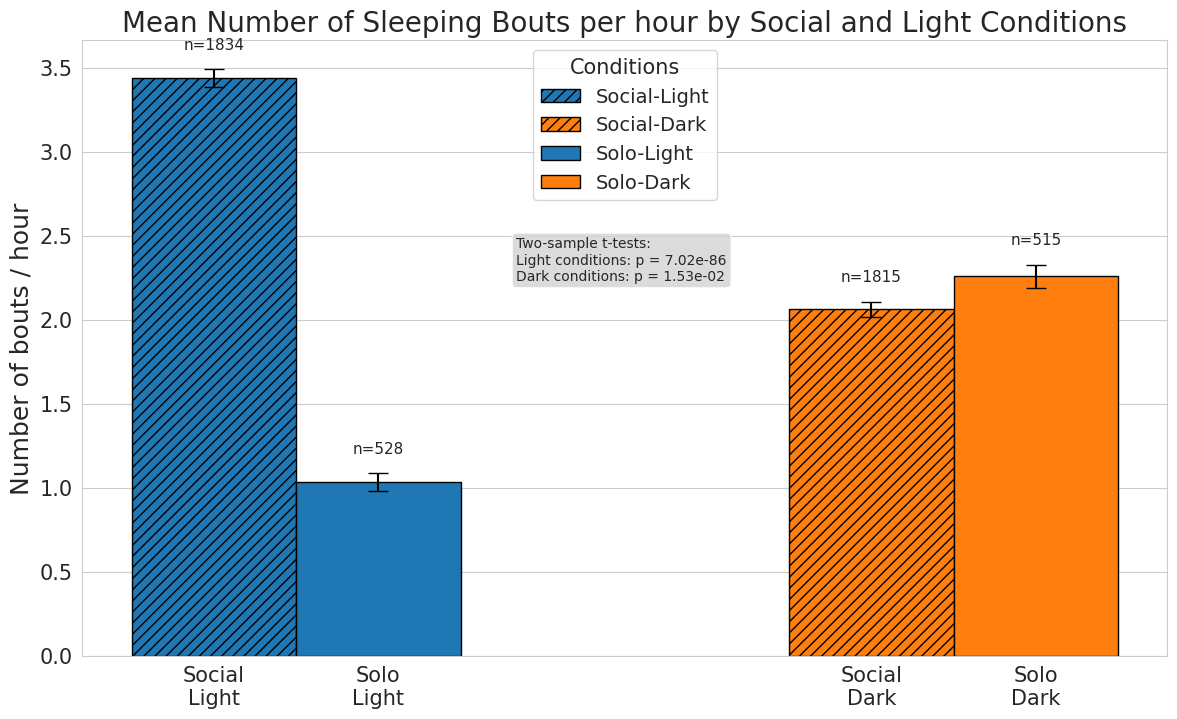

In [32]:
"""Plot bars of bouts per hour"""

fig, ax = plt.subplots(figsize=(14, 8))

summary_data = []
for social_val in ["social", "postsocial"]:
    for light_val in [True, False]:
        subset = sleep_hour_df[
            (sleep_hour_df["period"] == social_val)
            & (sleep_hour_df["light"] == light_val)
        ]
        mean_n_bouts = subset["n_bouts"].mean()
        sem_n_bouts = subset["n_bouts"].sem()
        n_samples = len(subset)
        summary_data.append(
            {
                "social": social_val,
                "light": light_val,
                "mean_n_bouts": mean_n_bouts,
                "sem": sem_n_bouts,
                "condition": (
                    f"{'Social' if social_val == 'social' else 'Solo'}-"
                    f"{'Light' if light_val else 'Dark'}"
                ),
                "n": n_samples,
            }
        )
summary_df = pd.DataFrame(summary_data)

# Set up positions for the bars
bar_width = 0.5
x_pos = np.array([0.25, 2.25, 0.75, 2.75])  # create two groups with a gap in the middle

# Plot bars
for i, row in enumerate(summary_data):
    pos = x_pos[i]
    social_val = row["social"]
    light_val = row["light"]

    bar = ax.bar(
        pos,
        row["mean_n_bouts"],
        bar_width,
        yerr=row["sem"],
        color=colors[light_val],
        edgecolor="black",
        capsize=7,
        label=row["condition"],
    )

    print(
        f"Plotting {row['condition']}: μ={row['mean_n_bouts']:.2f}, SEM={row['sem']:.2f}, n={row['n']}"
    )

    # Apply hatching for social conditions
    if hatches[social_val == "social"]:
        bar[0].set_hatch(hatches[social_val == "social"])

    # Add sample size as text above each bar
    sample_size_txt = ax.text(
        pos,
        row["mean_n_bouts"] + row["sem"] + 0.1,
        f"n={row['n']}",
        ha="center",
        va="bottom",
    )
    sample_size_txt.set_fontsize(11)

ax.set_title("Mean Number of Sleeping Bouts per hour by Social and Light Conditions")
ax.set_ylabel("Number of bouts / hour")
ax.set_xticks(x_pos)
ax.set_xticklabels(["Social\nLight", "Social\nDark", "Solo\nLight", "Solo\nDark"])
ax.legend(title="Conditions", loc="upper center")


# Perform stats tests
light_social = sleep_hour_df[
    (sleep_hour_df["period"] == "social") & (sleep_hour_df["light"] == True)
]["n_bouts"]
light_solo = sleep_hour_df[
    (sleep_hour_df["period"] == "social") & (sleep_hour_df["light"] == False)
]["n_bouts"]

dark_social = sleep_hour_df[
    (sleep_hour_df["period"] == "social") & (sleep_hour_df["light"] == False)
]["n_bouts"]
dark_solo = sleep_hour_df[
    (sleep_hour_df["period"] == "postsocial") & (sleep_hour_df["light"] == False)
]["n_bouts"]

light_social = pd.to_numeric(light_social, errors="coerce").dropna()
light_solo = pd.to_numeric(light_solo, errors="coerce").dropna()
dark_social = pd.to_numeric(dark_social, errors="coerce").dropna()
dark_solo = pd.to_numeric(dark_solo, errors="coerce").dropna()

light_stat, light_p = stats.ttest_ind(
    light_social, light_solo, alternative="two-sided", equal_var=False
)
dark_stat, dark_p = stats.ttest_ind(
    dark_social, dark_solo, alternative="two-sided", equal_var=False
)

test_text = (
    f"Two-sample t-tests:\n"
    f"Light conditions: p = {light_p:.2e}"
    f"\nDark conditions: p = {dark_p:.2e}"
)
props = dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8)
ax.text(
    0.40,
    0.68,  # Position below the legend
    test_text,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=props,
)


Plotting Social-Light: mean=6.33, sem=0.09, n=6308
Plotting Social-Dark: mean=4.20, sem=0.09, n=3743
Plotting Solo-Light: mean=48.14, sem=2.33, n=547
Plotting Solo-Dark: mean=11.79, sem=0.73, n=1164


Text(0.4, 0.68, 'Two-sample t-tests:\nLight conditions: p = 2.65e-65\nDark conditions: p = 5.44e-24')

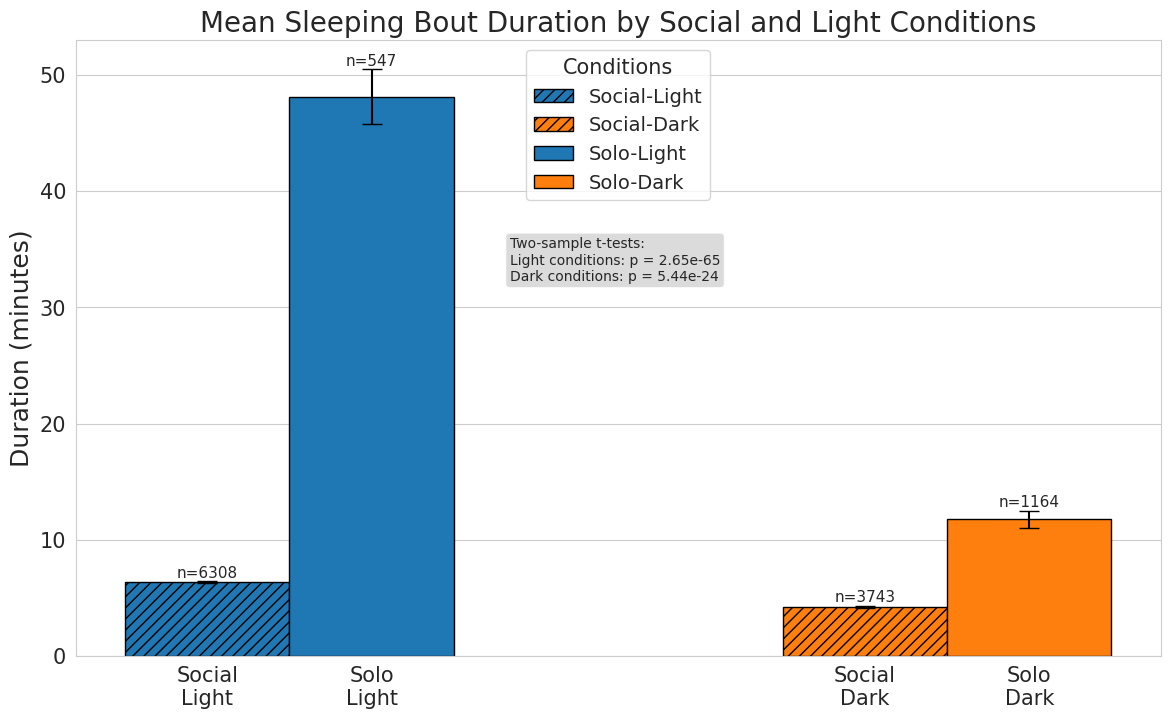

In [33]:
"""Plot bars of durations of bouts."""

fig, ax = plt.subplots(figsize=(14, 8))

summary_data = []
for social_val in ["social", "postsocial"]:
    for light_val in [True, False]:
        subset = sleep_dur_df[
            (sleep_dur_df["period"] == social_val)
            & (sleep_dur_df["light"] == light_val)
        ]
        mean_duration = subset["duration"].mean()
        sem_duration = subset["duration"].sem()
        n_samples = len(subset)
        summary_data.append(
            {
                "social": social_val,
                "light": light_val,
                "mean_duration": mean_duration,
                "sem": sem_duration,
                "condition": (
                    f"{'Social' if social_val == 'social' else 'Solo'}-"
                    f"{'Light' if light_val else 'Dark'}"
                ),
                "n": n_samples,
            }
        )
summary_df = pd.DataFrame(summary_data)

# Set up positions for the bars
bar_width = 0.5
x_pos = np.array([0.25, 2.25, 0.75, 2.75])  # create two groups with a gap in the middle

# Plot bars
for i, row in enumerate(summary_data):
    pos = x_pos[i]
    social_val = row["social"]
    light_val = row["light"]

    bar = ax.bar(
        pos,
        row["mean_duration"],
        bar_width,
        yerr=row["sem"],
        color=colors[light_val],
        edgecolor="black",
        capsize=7,
        label=row["condition"],
    )

    print(
        f"Plotting {row['condition']}: μ={row['mean_duration']:.2f}, SEM={row['sem']:.2f}, n={row['n']}"
    )

    # Apply hatching for social conditions
    if hatches[social_val == "social"]:
        bar[0].set_hatch(hatches[social_val == "social"])

    # Add sample size as text above each bar
    sample_size_txt = ax.text(
        pos,
        row["mean_duration"] + row["sem"] + 0.1,
        f"n={row['n']}",
        ha="center",
        va="bottom",
    )
    sample_size_txt.set_fontsize(11)

ax.set_title("Mean Sleeping Bout Duration by Social and Light Conditions")
ax.set_ylabel("Duration (minutes)")
ax.set_xticks(x_pos)
ax.set_xticklabels(["Social\nLight", "Social\nDark", "Solo\nLight", "Solo\nDark"])
ax.legend(title="Conditions", loc="upper center")
# Perform stats tests
light_social = sleep_dur_df[
    (sleep_dur_df["period"] == "social") & (sleep_dur_df["light"] == True)
]["duration"]
light_solo = sleep_dur_df[
    (sleep_dur_df["period"] == "social") & (sleep_dur_df["light"] == False)
]["duration"]

dark_social = sleep_dur_df[
    (sleep_dur_df["period"] == "social") & (sleep_dur_df["light"] == False)
]["duration"]
dark_solo = sleep_dur_df[
    (sleep_dur_df["period"] == "postsocial") & (sleep_dur_df["light"] == False)
]["duration"]

light_social = pd.to_numeric(light_social, errors="coerce").dropna()
light_solo = pd.to_numeric(light_solo, errors="coerce").dropna()
dark_social = pd.to_numeric(dark_social, errors="coerce").dropna()
dark_solo = pd.to_numeric(dark_solo, errors="coerce").dropna()

light_stat, light_p = stats.ttest_ind(
    light_social, light_solo, alternative="two-sided", equal_var=False
)
dark_stat, dark_p = stats.ttest_ind(
    dark_social, dark_solo, alternative="two-sided", equal_var=False
)

test_text = (
    f"Two-sample t-tests:\n"
    f"Light conditions: p = {light_p:.2e}"
    f"\nDark conditions: p = {dark_p:.2e}"
)
props = dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8)
ax.text(
    0.40,
    0.68,  # Position below the legend
    test_text,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=props,
)


Plotting Social-Light: mean=21.78, sem=0.38, n=1834
Plotting Social-Dark: mean=8.66, sem=0.28, n=1815
Plotting Solo-Light: mean=49.87, sem=2.53, n=528
Plotting Solo-Dark: mean=26.64, sem=1.59, n=515


Text(0.4, 0.68, 'Two-sample t-tests:\nLight conditions: p = 7.87e-151\nDark conditions: p = 3.93e-26')

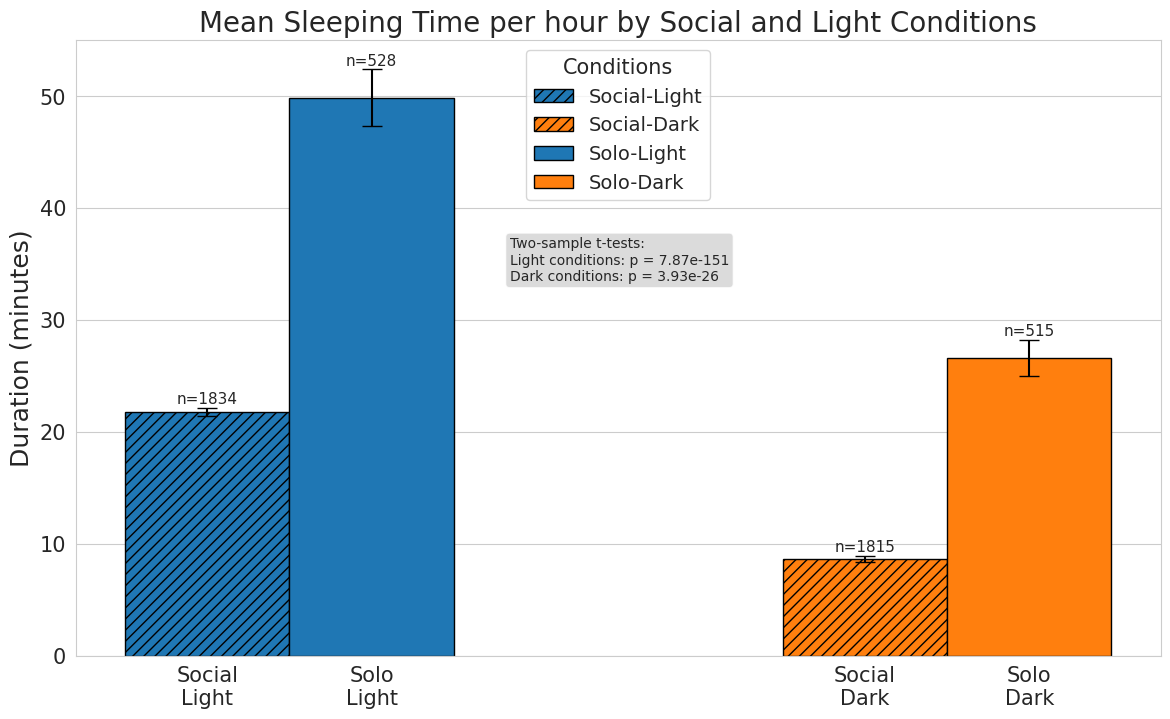

In [34]:
"""Total time spent sleeping per hour."""

fig, ax = plt.subplots(figsize=(14, 8))

summary_data = []
for social_val in ["social", "postsocial"]:
    for light_val in [True, False]:
        subset = sleep_hour_df[
            (sleep_hour_df["period"] == social_val)
            & (sleep_hour_df["light"] == light_val)
        ]
        mean_duration = subset["duration"].mean()
        sem_duration = subset["duration"].sem()
        n_samples = len(subset)
        summary_data.append(
            {
                "social": social_val,
                "light": light_val,
                "mean_duration": mean_duration,
                "sem": sem_duration,
                "condition": (
                    f"{'Social' if social_val == 'social' else 'Solo'}-"
                    f"{'Light' if light_val else 'Dark'}"
                ),
                "n": n_samples,
            }
        )
summary_df = pd.DataFrame(summary_data)

# Set up positions for the bars
bar_width = 0.5
x_pos = np.array([0.25, 2.25, 0.75, 2.75])  # create two groups with a gap in the middle

# Plot bars
for i, row in enumerate(summary_data):
    pos = x_pos[i]
    social_val = row["social"]
    light_val = row["light"]

    bar = ax.bar(
        pos,
        row["mean_duration"],
        bar_width,
        yerr=row["sem"],
        color=colors[light_val],
        edgecolor="black",
        capsize=7,
        label=row["condition"],
    )

    print(
        f"Plotting {row['condition']}: μ={row['mean_duration']:.2f}, SEM={row['sem']:.2f}, n={row['n']}"
    )

    # Apply hatching for social conditions
    if hatches[social_val == "social"]:
        bar[0].set_hatch(hatches[social_val == "social"])

    # Add sample size as text above each bar
    sample_size_txt = ax.text(
        pos,
        row["mean_duration"] + row["sem"] + 0.1,
        f"n={row['n']}",
        ha="center",
        va="bottom",
    )
    sample_size_txt.set_fontsize(11)

ax.set_title("Mean Sleeping Time per hour by Social and Light Conditions")
ax.set_ylabel("Duration (minutes)")
ax.set_xticks(x_pos)
ax.set_xticklabels(["Social\nLight", "Social\nDark", "Solo\nLight", "Solo\nDark"])
ax.legend(title="Conditions", loc="upper center")


# Perform stats tests
light_social = sleep_hour_df[
    (sleep_hour_df["period"] == "social") & (sleep_hour_df["light"] == True)
]["duration"]
light_solo = sleep_hour_df[
    (sleep_hour_df["period"] == "social") & (sleep_hour_df["light"] == False)
]["duration"]

dark_social = sleep_hour_df[
    (sleep_hour_df["period"] == "social") & (sleep_hour_df["light"] == False)
]["duration"]
dark_solo = sleep_hour_df[
    (sleep_hour_df["period"] == "postsocial") & (sleep_hour_df["light"] == False)
]["duration"]

light_social = pd.to_numeric(light_social, errors="coerce").dropna()
light_solo = pd.to_numeric(light_solo, errors="coerce").dropna()
dark_social = pd.to_numeric(dark_social, errors="coerce").dropna()
dark_solo = pd.to_numeric(dark_solo, errors="coerce").dropna()

light_stat, light_p = stats.ttest_ind(
    light_social, light_solo, alternative="two-sided", equal_var=False
)
dark_stat, dark_p = stats.ttest_ind(
    dark_social, dark_solo, alternative="two-sided", equal_var=False
)

test_text = (
    f"Two-sample t-tests:\n"
    f"Light conditions: p = {light_p:.2e}"
    f"\nDark conditions: p = {dark_p:.2e}"
)
props = dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8)
ax.text(
    0.40,
    0.68,  # Position below the legend
    test_text,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=props,
)


### Drinking

- n_bouts / hour
- duration of bouts
- total time spent drinking / hour

In [ ]:
drink_dur_df = pd.DataFrame(
    columns=["subject", "start", "end", "duration", "period", "light"]
)
drink_hour_df = pd.DataFrame(
    columns=["subject", "hour", "n_bouts", "duration", "period", "light"]
)

exp_pbar = tqdm(experiments, desc="Experiments", position=0, leave=True)
for exp in exp_pbar:
    if exp["name"] == "social0.3-aeon4":
        continue  # Skip this experiment as the data is not available
    period_pbar = tqdm(periods, desc="Periods", position=1, leave=False)
    for period in period_pbar:
        sleep_bouts_df = load_data_from_parquet(
            experiment_name=exp["name"],
            period=period,
            data_type="drink",
            data_dir=data_dir,
            set_time_index=True,
        )

        # Get drink bout durations
        hour = sleep_bouts_df["start"].dt.hour
        sleep_bouts_df["light"] = ~((hour > light_off) & (hour < light_on))
        drink_dur_df = pd.concat([drink_dur_df, sleep_bouts_df], ignore_index=True)

        # Get n drink bouts and total duration per hour
        for subject in sleep_bouts_df["subject"].unique():
            sleep_df_subj = sleep_bouts_df[sleep_bouts_df["subject"] == subject]
            sleep_df_subj["hour"] = sleep_df_subj["start"].dt.floor("h")
            hour_stats = (
                sleep_df_subj.groupby("hour")
                .agg({"duration": ["count", "sum"]})
                .reset_index()
            )
            hour_stats.columns = ["hour", "n_bouts", "duration"]

            min_hour, max_hour = (
                sleep_df_subj["hour"].min(),
                sleep_df_subj["hour"].max(),
            )
            complete_hours = pd.DataFrame(
                {"hour": pd.date_range(start=min_hour, end=max_hour, freq="h")}
            )
            sleep_df_subj_hour = pd.merge(
                complete_hours, hour_stats, on="hour", how="left"
            ).fillna(0)
            sleep_df_subj_hour["n_bouts"] = sleep_df_subj_hour["n_bouts"].astype(int)
            sleep_df_subj_hour["period"] = period
            sleep_df_subj_hour["subject"] = subject
            hour = sleep_df_subj_hour["hour"].dt.hour
            sleep_df_subj_hour["light"] = ~((hour > light_off) & (hour < light_on))
            drink_hour_df = pd.concat(
                [drink_hour_df, sleep_df_subj_hour], ignore_index=True
            )

drink_dur_df["duration"] = (
    pd.to_timedelta(drink_dur_df["duration"]).dt.total_seconds() / 60
)
drink_hour_df["duration"] = (
    pd.to_timedelta(drink_hour_df["duration"]).dt.total_seconds() / 60
)

Plotting Social-Light: mean=6.59, sem=0.33, n=1498
Plotting Social-Dark: mean=12.53, sem=0.32, n=1498
Plotting Solo-Light: mean=2.09, sem=0.18, n=432
Plotting Solo-Dark: mean=10.43, sem=0.41, n=430


Text(0.4, 0.68, 'Two-sample t-tests:\nLight conditions: p = 2.30e-36\nDark conditions: p = 6.68e-05')

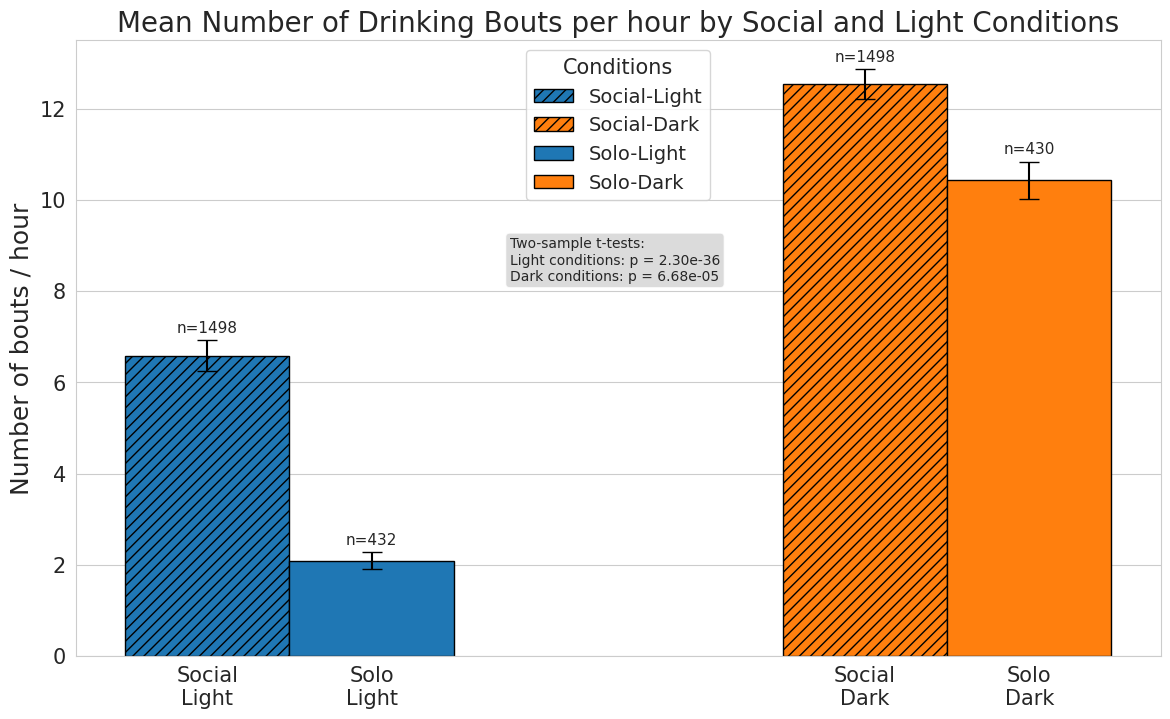

In [26]:
"""Number of drinking bouts per hour bars."""

fig, ax = plt.subplots(figsize=(14, 8))

summary_data = []
for social_val in ["social", "postsocial"]:
    for light_val in [True, False]:
        subset = drink_hour_df[
            (drink_hour_df["period"] == social_val)
            & (drink_hour_df["light"] == light_val)
        ]
        mean_n_bouts = subset["n_bouts"].mean()
        sem_n_bouts = subset["n_bouts"].sem()
        n_samples = len(subset)
        summary_data.append(
            {
                "social": social_val,
                "light": light_val,
                "mean_n_bouts": mean_n_bouts,
                "sem": sem_n_bouts,
                "condition": (
                    f"{'Social' if social_val == 'social' else 'Solo'}-"
                    f"{'Light' if light_val else 'Dark'}"
                ),
                "n": n_samples,
            }
        )
summary_df = pd.DataFrame(summary_data)

# Set up positions for the bars
bar_width = 0.5
x_pos = np.array([0.25, 2.25, 0.75, 2.75])  # create two groups with a gap in the middle

# Plot bars
for i, row in enumerate(summary_data):
    pos = x_pos[i]
    social_val = row["social"]
    light_val = row["light"]

    bar = ax.bar(
        pos,
        row["mean_n_bouts"],
        bar_width,
        yerr=row["sem"],
        color=colors[light_val],
        edgecolor="black",
        capsize=7,
        label=row["condition"],
    )

    print(
        f"Plotting {row['condition']}: μ={row['mean_n_bouts']:.2f}, SEM={row['sem']:.2f}, n={row['n']}"
    )

    # Apply hatching for social conditions
    if hatches[social_val == "social"]:
        bar[0].set_hatch(hatches[social_val == "social"])

    # Add sample size as text above each bar
    sample_size_txt = ax.text(
        pos,
        row["mean_n_bouts"] + row["sem"] + 0.1,
        f"n={row['n']}",
        ha="center",
        va="bottom",
    )
    sample_size_txt.set_fontsize(11)

ax.set_title("Mean Number of Drinking Bouts per hour by Social and Light Conditions")
ax.set_ylabel("Number of bouts / hour")
ax.set_xticks(x_pos)
ax.set_xticklabels(["Social\nLight", "Social\nDark", "Solo\nLight", "Solo\nDark"])
# ax.set_ylim([0, 2.01])
ax.legend(title="Conditions", loc="upper center")


# Perform stats tests
light_social = drink_hour_df[
    (drink_hour_df["period"] == "social") & (drink_hour_df["light"] == True)
]["n_bouts"]
light_solo = drink_hour_df[
    (drink_hour_df["period"] == "social") & (drink_hour_df["light"] == False)
]["n_bouts"]

dark_social = drink_hour_df[
    (drink_hour_df["period"] == "social") & (drink_hour_df["light"] == False)
]["n_bouts"]
dark_solo = drink_hour_df[
    (drink_hour_df["period"] == "postsocial") & (drink_hour_df["light"] == False)
]["n_bouts"]

light_social = pd.to_numeric(light_social, errors="coerce").dropna()
light_solo = pd.to_numeric(light_solo, errors="coerce").dropna()
dark_social = pd.to_numeric(dark_social, errors="coerce").dropna()
dark_solo = pd.to_numeric(dark_solo, errors="coerce").dropna()

light_stat, light_p = stats.ttest_ind(
    light_social, light_solo, alternative="two-sided", equal_var=False
)
dark_stat, dark_p = stats.ttest_ind(
    dark_social, dark_solo, alternative="two-sided", equal_var=False
)

test_text = (
    f"Two-sample t-tests:\n"
    f"Light conditions: p = {light_p:.2e}"
    f"\nDark conditions: p = {dark_p:.2e}"
)
props = dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8)
ax.text(
    0.40,
    0.68,  # Position below the legend
    test_text,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=props,
)

Text(0.4, 0.68, 'Two-sample t-tests:\nLight conditions: p = 3.68e-64\nDark conditions: p = 1.10e-04')

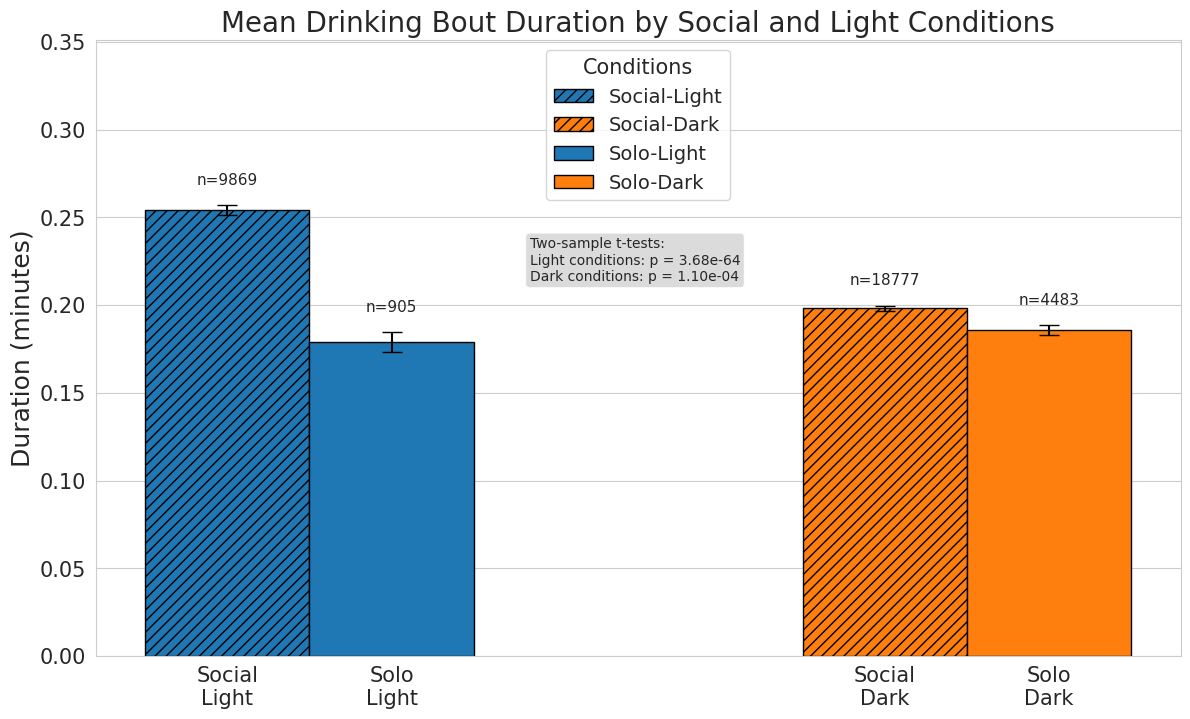

In [27]:
"""Plot bars of durations of bouts."""

fig, ax = plt.subplots(figsize=(14, 8))

summary_data = []
for social_val in ["social", "postsocial"]:
    for light_val in [True, False]:
        subset = drink_dur_df[
            (drink_dur_df["period"] == social_val)
            & (drink_dur_df["light"] == light_val)
        ]
        mean_duration = subset["duration"].mean()
        sem_duration = subset["duration"].sem()
        n_samples = len(subset)
        summary_data.append(
            {
                "social": social_val,
                "light": light_val,
                "mean_duration": mean_duration,
                "sem": sem_duration,
                "condition": (
                    f"{'Social' if social_val == 'social' else 'Solo'}-"
                    f"{'Light' if light_val else 'Dark'}"
                ),
                "n": n_samples,
            }
        )
summary_df = pd.DataFrame(summary_data)

# Set up positions for the bars
bar_width = 0.5
x_pos = np.array([0.25, 2.25, 0.75, 2.75])  # create two groups with a gap in the middle

# Plot bars
for i, row in enumerate(summary_data):
    pos = x_pos[i]
    social_val = row["social"]
    light_val = row["light"]

    bar = ax.bar(
        pos,
        row["mean_duration"],
        bar_width,
        yerr=row["sem"],
        color=colors[light_val],
        edgecolor="black",
        capsize=7,
        label=row["condition"],
    )

    # Apply hatching for social conditions
    if hatches[social_val == "social"]:
        bar[0].set_hatch(hatches[social_val == "social"])

    # Add sample size as text above each bar
    sample_size_txt = ax.text(
        pos,
        row["mean_duration"] + row["sem"] + 0.01,
        f"n={row['n']}",
        ha="center",
        va="bottom",
    )
    sample_size_txt.set_fontsize(11)

ax.set_title("Mean Drinking Bout Duration by Social and Light Conditions")
ax.set_ylabel("Duration (minutes)")
ax.set_xticks(x_pos)
ax.set_ylim([0, 0.351])
ax.set_xticklabels(["Social\nLight", "Social\nDark", "Solo\nLight", "Solo\nDark"])
ax.legend(title="Conditions", loc="upper center")
# Perform stats tests
light_social = drink_dur_df[
    (drink_dur_df["period"] == "social") & (drink_dur_df["light"] == True)
]["duration"]
light_solo = drink_dur_df[
    (drink_dur_df["period"] == "social") & (drink_dur_df["light"] == False)
]["duration"]

dark_social = drink_dur_df[
    (drink_dur_df["period"] == "social") & (drink_dur_df["light"] == False)
]["duration"]
dark_solo = drink_dur_df[
    (drink_dur_df["period"] == "postsocial") & (drink_dur_df["light"] == False)
]["duration"]

light_social = pd.to_numeric(light_social, errors="coerce").dropna()
light_solo = pd.to_numeric(light_solo, errors="coerce").dropna()
dark_social = pd.to_numeric(dark_social, errors="coerce").dropna()
dark_solo = pd.to_numeric(dark_solo, errors="coerce").dropna()

light_stat, light_p = stats.ttest_ind(
    light_social, light_solo, alternative="two-sided", equal_var=False
)
dark_stat, dark_p = stats.ttest_ind(
    dark_social, dark_solo, alternative="two-sided", equal_var=False
)

test_text = (
    f"Two-sample t-tests:\n"
    f"Light conditions: p = {light_p:.2e}"
    f"\nDark conditions: p = {dark_p:.2e}"
)
props = dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8)
ax.text(
    0.40,
    0.68,  # Position below the legend
    test_text,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=props,
)


Text(0.4, 0.68, 'Two-sample t-tests:\nLight conditions: p = 9.74e-13\nDark conditions: p = 6.84e-07')

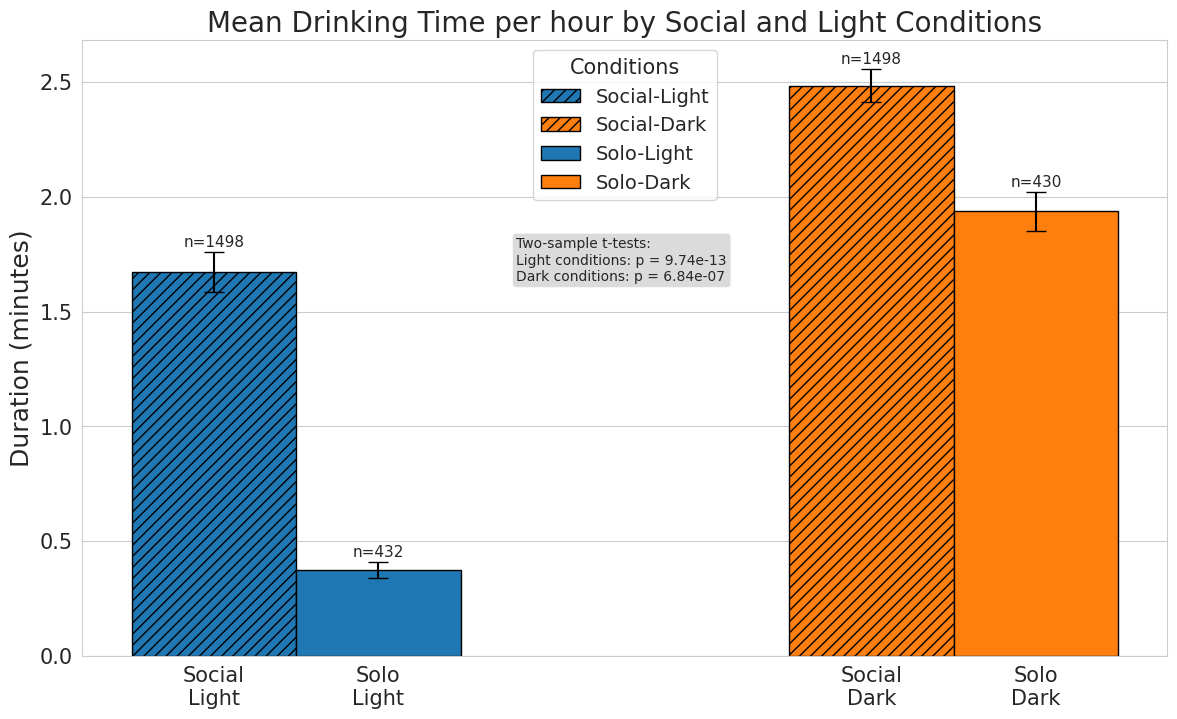

In [28]:
"""Total time spent drinking per hour."""

fig, ax = plt.subplots(figsize=(14, 8))

summary_data = []
for social_val in ["social", "postsocial"]:
    for light_val in [True, False]:
        subset = drink_hour_df[
            (drink_hour_df["period"] == social_val)
            & (drink_hour_df["light"] == light_val)
        ]
        mean_duration = subset["duration"].mean()
        sem_duration = subset["duration"].sem()
        n_samples = len(subset)
        summary_data.append(
            {
                "social": social_val,
                "light": light_val,
                "mean_duration": mean_duration,
                "sem": sem_duration,
                "condition": (
                    f"{'Social' if social_val == 'social' else 'Solo'}-"
                    f"{'Light' if light_val else 'Dark'}"
                ),
                "n": n_samples,
            }
        )
summary_df = pd.DataFrame(summary_data)

# Set up positions for the bars
bar_width = 0.5
x_pos = np.array([0.25, 2.25, 0.75, 2.75])  # create two groups with a gap in the middle

# Plot bars
for i, row in enumerate(summary_data):
    pos = x_pos[i]
    social_val = row["social"]
    light_val = row["light"]

    bar = ax.bar(
        pos,
        row["mean_duration"],
        bar_width,
        yerr=row["sem"],
        color=colors[light_val],
        edgecolor="black",
        capsize=7,
        label=row["condition"],
    )

    # Apply hatching for social conditions
    if hatches[social_val == "social"]:
        bar[0].set_hatch(hatches[social_val == "social"])

    # Add sample size as text above each bar
    sample_size_txt = ax.text(
        pos,
        row["mean_duration"] + row["sem"] + 0.01,
        f"n={row['n']}",
        ha="center",
        va="bottom",
    )
    sample_size_txt.set_fontsize(11)

ax.set_title("Mean Drinking Time per hour by Social and Light Conditions")
ax.set_ylabel("Duration (minutes)")
ax.set_xticks(x_pos)
ax.set_xticklabels(["Social\nLight", "Social\nDark", "Solo\nLight", "Solo\nDark"])
ax.legend(title="Conditions", loc="upper center")


# Perform stats tests
light_social = drink_hour_df[
    (drink_hour_df["period"] == "social") & (drink_hour_df["light"] == True)
]["duration"]
light_solo = drink_hour_df[
    (drink_hour_df["period"] == "social") & (drink_hour_df["light"] == False)
]["duration"]

dark_social = drink_hour_df[
    (drink_hour_df["period"] == "social") & (drink_hour_df["light"] == False)
]["duration"]
dark_solo = drink_hour_df[
    (drink_hour_df["period"] == "postsocial") & (drink_hour_df["light"] == False)
]["duration"]

light_social = pd.to_numeric(light_social, errors="coerce").dropna()
light_solo = pd.to_numeric(light_solo, errors="coerce").dropna()
dark_social = pd.to_numeric(dark_social, errors="coerce").dropna()
dark_solo = pd.to_numeric(dark_solo, errors="coerce").dropna()

light_stat, light_p = stats.ttest_ind(
    light_social, light_solo, alternative="two-sided", equal_var=False
)
dark_stat, dark_p = stats.ttest_ind(
    dark_social, dark_solo, alternative="two-sided", equal_var=False
)

test_text = (
    f"Two-sample t-tests:\n"
    f"Light conditions: p = {light_p:.2e}"
    f"\nDark conditions: p = {dark_p:.2e}"
)
props = dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8)
ax.text(
    0.40,
    0.68,  # Position below the legend
    test_text,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=props,
)


## Solo vs. Social Learning

In [10]:
learning_df = pd.DataFrame(  # per-block, per-subject
    columns=[
        "experiment_name",
        "period",
        "block_start",
        "block_type",  # "lll", "lmh", or "hhh"
        "block_type_rate",  # "l" (100, 300, 500) or "h" (200, 600, 1000)
        "subject_name",
        "pel_thresh",  # sorted by time
        "pel_patch",  # "l", "m", or "h"
        "running_patch_pref_low",  # every X foraging dist
        "running_patch_pref_high",  # every X foraging dist
        "final_patch_pref_low",  # final patch pref
        "final_patch_pref_high",  # final patch pref
        "dist_forage_low",  # final distance foraged
        "dist_forage_med",  # final distance foraged
        "dist_forage_high",  # final distance foraged
    ]
)

In [11]:
def find_first_x_indxs(
    dist_forage: np.ndarray, dist_threshold: np.ndarray
) -> np.ndarray:
    """For each value in dist_threshold, find the first index in dist_forage that exceeds this."""
    idxs = np.searchsorted(dist_forage, dist_threshold)
    idxs = idxs[idxs < len(dist_forage)]
    return idxs

In [12]:
def create_patch_name_type_map(block_start, subject_name, patch_df):
    # Filter patch_df for this specific block_start and subject_name
    relevant_patches = patch_df[
        (patch_df["block_start"] == block_start)
        & (patch_df["subject_name"] == subject_name)
    ]

    # Initialize the mapping dictionary
    patch_name_type_map = {"l": [], "m": [], "h": []}

    # Group by patch_type and collect patch_names
    for patch_type, group in relevant_patches.groupby("patch_type"):
        patch_names = group["patch_name"].unique().tolist()
        patch_name_type_map[patch_type] = patch_names

    return patch_name_type_map

In [ ]:
pref_every = np.arange(0, 16000, 400)  # cm
frg_blk_pel_thresh = 3  # pellets

exp_pbar = tqdm(experiments, desc="Experiments", position=0, leave=True)
for exp in exp_pbar:
    period_pbar = tqdm(periods, desc="Periods", position=1, leave=False)
    for period in period_pbar:
        cur_learning_df = pd.DataFrame(columns=learning_df.columns)

        # <s> Load all relevant patch data
        patchinfo_df = load_data_from_parquet(
            experiment_name=exp["name"],
            period=period,
            data_type="patchinfo",
            data_dir=data_dir,
            set_time_index=True,
        )
        patch_df = load_data_from_parquet(
            experiment_name=exp["name"],
            period=period,
            data_type="patch",
            data_dir=data_dir,
            set_time_index=True,
        )
        patchpref_df = load_data_from_parquet(
            experiment_name=exp["name"],
            period=period,
            data_type="patchpref",
            data_dir=data_dir,
            set_time_index=True,
        )
        # </s>

        # <s> Clean up `patchinfo_df` and `patch_df`
        patch_df = patch_df[patch_df["patch_name"] != "PatchDummy1"]
        patchinfo_df = patchinfo_df[patchinfo_df["patch_name"] != "PatchDummy1"]

        # Drop blocks where 'patch_rate' is NaN or None
        nan_patch_rate_rows = patchinfo_df[patchinfo_df["patch_rate"].isna()]
        unique_block_starts_to_drop = nan_patch_rate_rows["block_start"].unique()
        if len(unique_block_starts_to_drop) != 0:
            warn(
                f"{exp['name']} {period} blocks with missing patch rate(s): "
                f"{unique_block_starts_to_drop}",
                stacklevel=1,
            )
            patchinfo_df = patchinfo_df[
                ~patchinfo_df["block_start"].isin(unique_block_starts_to_drop)
            ]
            patch_df = patch_df[
                ~patch_df["block_start"].isin(unique_block_starts_to_drop)
            ]

        # patch_df = patch_df[patch_df["pellet_count"] > 0]

        # Get patch type per row: for each row in `patch_df`, find the equivalent row in
        # `patchinfo_df` (based on 'block_start' and 'patch_name'), and get the patch_type
        # from the map.
        patchinfo_lookup = patchinfo_df.set_index(["block_start", "patch_name"])[
            "patch_rate"
        ].to_dict()

        patch_df["patch_type"] = patch_df.apply(
            lambda row: patch_type_rate_map[
                patchinfo_lookup[(row["block_start"], row["patch_name"])]
            ],
            axis=1,
        )
        patch_df["patch_type_per_pellet"] = patch_df.apply(
            lambda row: np.full(len(row["pellet_timestamps"]), row["patch_type"]),
            axis=1,
        )
        # </s>

        # <s> Get pel_thresh and pel_patch cols
        patch_df_block_subj = patch_df.groupby(["block_start", "subject_name"]).agg(
            dist_forage=("wheel_cumsum_distance_travelled", lambda x: x.sum()),
            pellet_count=("pellet_count", lambda x: x.sum()),
            pellet_threshold=("patch_threshold", lambda x: np.concatenate(x.values)),
            pellet_timestamp=("pellet_timestamps", lambda x: np.concatenate(x.values)),
            patch_type=("patch_type_per_pellet", lambda x: np.concatenate(x.values)),
        )
        patch_df_block_subj = patch_df_block_subj[
            patch_df_block_subj["pellet_count"] >= frg_blk_pel_thresh
        ]
        patch_df_block_subj.reset_index(inplace=True)

        # for each row, get patch_threshold sorted ascending by pellet_timestamps
        cur_learning_df["pel_thresh"] = patch_df_block_subj.apply(
            lambda row: np.array(row["pellet_threshold"])[
                np.argsort(row["pellet_timestamp"])
            ],
            axis=1,
        )
        cur_learning_df["pel_patch"] = patch_df_block_subj.apply(
            lambda row: np.array(row["patch_type"])[
                np.argsort(row["pellet_timestamp"])
            ],
            axis=1,
        )
        # </s>

        # <s> Get metrics by patch type
        # get low, med, high patch for all blocks
        patch_df_block_subj["patch_name_type_map"] = patch_df_block_subj.apply(
            lambda row: create_patch_name_type_map(
                row["block_start"], row["subject_name"], patch_df
            ),
            axis=1,
        )
        # get pref_idxs from `patch_df_block_subj["dist_forage"]` at each
        # cum `pref_every` dist
        pref_every_thresh_idxs = patch_df_block_subj["dist_forage"].apply(
            lambda x: find_first_x_indxs(x, pref_every)  # type: ignore
        )
        # get preference for these patches at `pref_every_thresh_idxs`
        patchpref_df = patchpref_df[
            patchpref_df["block_start"].isin(patch_df_block_subj["block_start"])
        ]

        for block_i, block in enumerate(patch_df_block_subj.itertuples()):
            # Get the patch name type mapping for this block-subject combination
            patch_map = block.patch_name_type_map

            if len(patch_map["l"]) == 0:  # hhh block
                col_pos = cur_learning_df.columns.get_loc("block_type")
                cur_learning_df.iat[block_i, col_pos] = "hhh"

                # runnning patch pref
                col_pos = cur_learning_df.columns.get_loc("running_patch_pref_low")
                cur_learning_df.iat[block_i, col_pos] = np.zeros(
                    len(pref_every_thresh_idxs[block_i])
                )
                col_pos = cur_learning_df.columns.get_loc("running_patch_pref_high")
                cur_learning_df.iat[block_i, col_pos] = np.ones(
                    len(pref_every_thresh_idxs[block_i])
                )

                # final patch pref
                col_pos = cur_learning_df.columns.get_loc("final_patch_pref_low")
                cur_learning_df.iat[block_i, col_pos] = 0
                col_pos = cur_learning_df.columns.get_loc("final_patch_pref_high")
                cur_learning_df.iat[block_i, col_pos] = 1

                # dist forage
                col_pos = cur_learning_df.columns.get_loc("dist_forage_low")
                cur_learning_df.iat[block_i, col_pos] = 0
                col_pos = cur_learning_df.columns.get_loc("dist_forage_med")
                cur_learning_df.iat[block_i, col_pos] = 0
                col_pos = cur_learning_df.columns.get_loc("dist_forage_high")
                cur_learning_df.iat[block_i, col_pos] = max(
                    0, patch_df_block_subj["dist_forage"].iloc[block_i][-1]
                )

            elif len(patch_map["l"]) == 3:  # lll block
                col_pos = cur_learning_df.columns.get_loc("block_type")
                cur_learning_df.iat[block_i, col_pos] = "lll"

                # runnning patch pref
                col_pos = cur_learning_df.columns.get_loc("running_patch_pref_low")
                cur_learning_df.iat[block_i, col_pos] = np.ones(
                    len(pref_every_thresh_idxs[block_i])
                )
                col_pos = cur_learning_df.columns.get_loc("running_patch_pref_high")
                cur_learning_df.iat[block_i, col_pos] = np.zeros(
                    len(pref_every_thresh_idxs[block_i])
                )

                # final patch pref
                col_pos = cur_learning_df.columns.get_loc("final_patch_pref_low")
                cur_learning_df.iat[block_i, col_pos] = 1
                col_pos = cur_learning_df.columns.get_loc("final_patch_pref_high")
                cur_learning_df.iat[block_i, col_pos] = 0

                # dist forage
                col_pos = cur_learning_df.columns.get_loc("dist_forage_low")
                cur_learning_df.iat[block_i, col_pos] = max(
                    0, patch_df_block_subj["dist_forage"].iloc[block_i][-1]
                )
                col_pos = cur_learning_df.columns.get_loc("dist_forage_med")
                cur_learning_df.iat[block_i, col_pos] = 0
                col_pos = cur_learning_df.columns.get_loc("dist_forage_high")
                cur_learning_df.iat[block_i, col_pos] = 0

            elif len(patch_map["l"]) == 1:  # lmh block
                col_pos = cur_learning_df.columns.get_loc("block_type")
                cur_learning_df.iat[block_i, col_pos] = "lmh"

                # runnning patch pref
                l_patch = patch_map["l"][0]
                col_pos = cur_learning_df.columns.get_loc("running_patch_pref_low")
                l_patch_data = patchpref_df[
                    (patchpref_df["block_start"] == block.block_start)
                    & (patchpref_df["patch_name"] == l_patch)
                    & (patchpref_df["subject_name"] == block.subject_name)
                ]
                cur_learning_df.iat[block_i, col_pos] = l_patch_data[
                    "running_preference_by_wheel"
                ].values[0][pref_every_thresh_idxs[block_i]]

                h_patch = patch_map["h"][0]  # Fixed: was using 'm' instead of 'h'
                col_pos = cur_learning_df.columns.get_loc("running_patch_pref_high")
                h_patch_data = patchpref_df[
                    (patchpref_df["block_start"] == block.block_start)
                    & (patchpref_df["patch_name"] == h_patch)
                    & (patchpref_df["subject_name"] == block.subject_name)
                ]
                cur_learning_df.iat[block_i, col_pos] = h_patch_data[
                    "running_preference_by_wheel"
                ].values[0][pref_every_thresh_idxs[block_i]]

                # final patch pref
                col_pos = cur_learning_df.columns.get_loc("final_patch_pref_low")
                cur_learning_df.iat[block_i, col_pos] = l_patch_data[
                    "final_preference_by_wheel"
                ].values[0]
                col_pos = cur_learning_df.columns.get_loc("final_patch_pref_high")
                cur_learning_df.iat[block_i, col_pos] = h_patch_data[
                    "final_preference_by_wheel"
                ].values[0]

                # final dist forage
                col_pos = cur_learning_df.columns.get_loc("dist_forage_low")
                patch_data = patch_df[
                    (patch_df["block_start"] == block.block_start)
                    & (patch_df["patch_type"] == "l")
                    & (patch_df["subject_name"] == block.subject_name)
                ]
                if not patch_data.empty:
                    cur_learning_df.iat[block_i, col_pos] = max(
                        0, patch_data["wheel_cumsum_distance_travelled"].values[0][-1]
                    )
                else:
                    cur_learning_df.iat[block_i, col_pos] = 0

                col_pos = cur_learning_df.columns.get_loc("dist_forage_med")
                patch_data = patch_df[
                    (patch_df["block_start"] == block.block_start)
                    & (patch_df["patch_type"] == "m")
                    & (patch_df["subject_name"] == block.subject_name)
                ]
                if not patch_data.empty:
                    cur_learning_df.iat[block_i, col_pos] = max(
                        0, patch_data["wheel_cumsum_distance_travelled"].values[0][-1]
                    )
                else:
                    cur_learning_df.iat[block_i, col_pos] = 0

                col_pos = cur_learning_df.columns.get_loc("dist_forage_high")
                patch_data = patch_df[
                    (patch_df["block_start"] == block.block_start)
                    & (patch_df["patch_type"] == "h")
                    & (patch_df["subject_name"] == block.subject_name)
                ]
                if not patch_data.empty:
                    cur_learning_df.iat[block_i, col_pos] = max(
                        0, patch_data["wheel_cumsum_distance_travelled"].values[0][-1]
                    )
                else:
                    cur_learning_df.iat[block_i, col_pos] = 0

        # </s>

        # <s> Fill in rest of `cur_learning_df` cols
        cur_learning_df["experiment_name"] = exp["name"]
        cur_learning_df["period"] = period
        cur_learning_df["block_start"] = patch_df_block_subj["block_start"]
        cur_learning_df["subject_name"] = patch_df_block_subj["subject_name"]

        # Get overall block type rate based on patch rates
        min_patch_rate = patchinfo_df.groupby(["block_start"]).agg(
            patch_rate=("patch_rate", lambda x: x.max())
        )
        min_patch_rate["block_type_rate"] = min_patch_rate["patch_rate"].map(
            {0.002: "l", 0.01: "l", 0.001: "h", 0.005: "h"}
        )
        cur_learning_df["block_type_rate"] = cur_learning_df["block_start"].map(
            min_patch_rate["block_type_rate"]
        )

        # </s>

        learning_df = pd.concat([learning_df, cur_learning_df], ignore_index=True)

In [14]:
# Different exps have different patch rates, so we scale the exps with smaller mean
# patch rates to match the exps with larger mean patch rates.
scaled_learning_df = learning_df.copy()

scaled_learning_df.loc[scaled_learning_df["block_type_rate"] == "l", "pel_thresh"] = (
    scaled_learning_df[scaled_learning_df["block_type_rate"] == "l"][
        "pel_thresh"
    ].apply(lambda x: np.array(x) * 2)
)

# same scaling for 'dist_forage_low', 'dist_forage_med', 'dist_forage_high'
scaled_learning_df.loc[
    scaled_learning_df["block_type_rate"] == "l", "dist_forage_low"
] = scaled_learning_df[scaled_learning_df["block_type_rate"] == "l"][
    "dist_forage_low"
].apply(lambda x: x * 2)

scaled_learning_df.loc[
    scaled_learning_df["block_type_rate"] == "l", "dist_forage_med"
] = scaled_learning_df[scaled_learning_df["block_type_rate"] == "l"][
    "dist_forage_med"
].apply(lambda x: x * 2)

scaled_learning_df.loc[
    scaled_learning_df["block_type_rate"] == "l", "dist_forage_high"
] = scaled_learning_df[scaled_learning_df["block_type_rate"] == "l"][
    "dist_forage_high"
].apply(lambda x: x * 2)

### Foraging efficiency over time

pellet-threshold as a function of block-pellet-number for "foraging" blocks

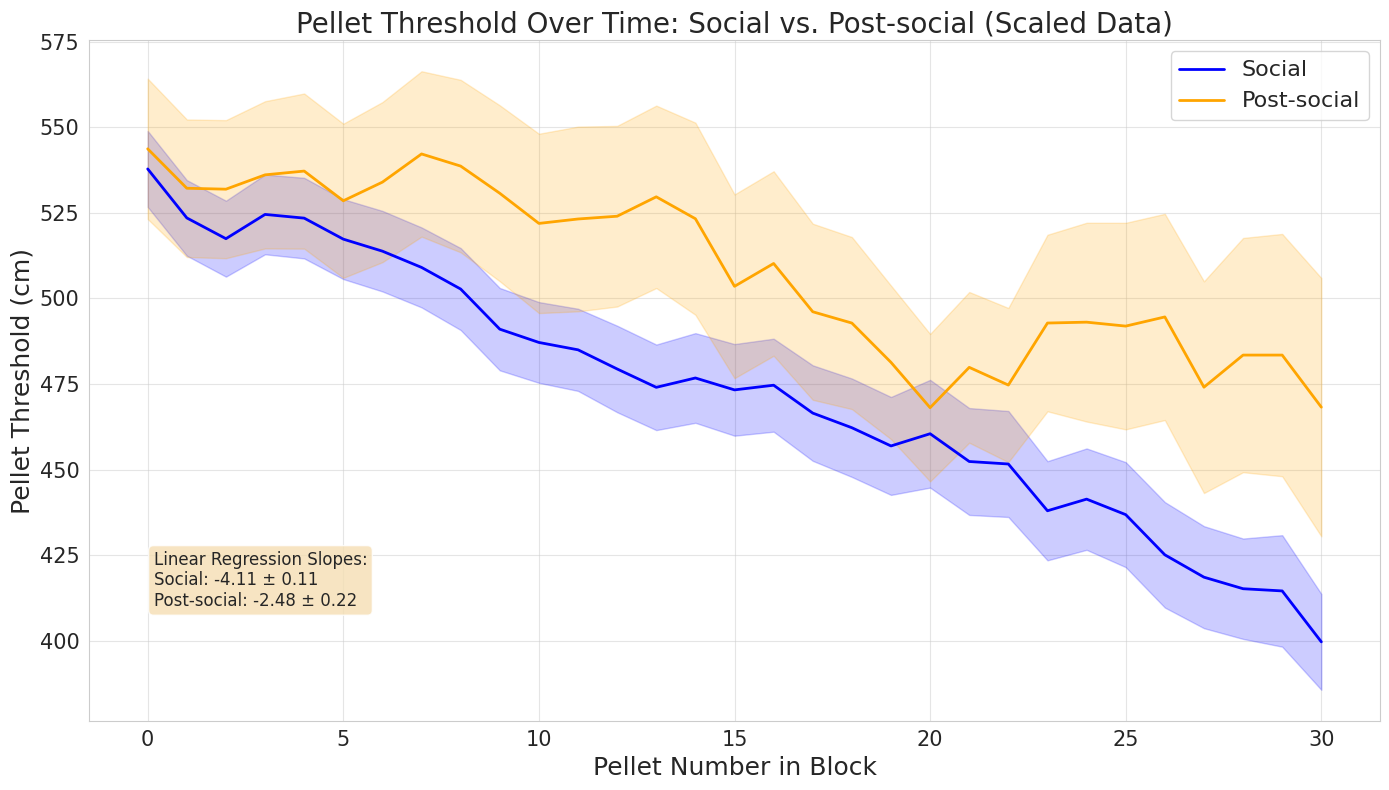

T-test (Scaled Data): t=-4.425, p=0.00005
Social slope: -4.114 ± 0.106, p=0.00000
Post-social slope: -2.478 ± 0.216, p=0.00000


In [15]:
# Pellet Threshold Over Time: Social vs. Post-social (Scaled Data)
# Similar to foraging efficiency plot but using scaled_learning_df

# Helper function to pad arrays to a uniform length
def pad_array(arr, max_len):
    return np.pad(arr, (0, max_len - len(arr)), mode="constant", constant_values=np.nan)


# Social and postsocial data processing using scaled data
social_rows_scaled = scaled_learning_df[
    (scaled_learning_df["period"] == "social")
    # & (scaled_learning_df["block_type"] == "lmh")
]
postsocial_rows_scaled = scaled_learning_df[
    (scaled_learning_df["period"] == "postsocial")
    # & (scaled_learning_df["block_type"] == "lmh")
]

# Set the cutoff lengths (same as original plot)
social_cutoff = 37
postsocial_cutoff = 37

# Smoothing parameters (same as original plot)
social_smooth_window = 7
postsocial_smooth_window = 7

# Option to normalize x-axis
normalize_x_axis = False  # Set to True for unit-normalized x-axis

# Process social data from scaled_learning_df
social_thresh_arrays_scaled = [
    arr[:social_cutoff] for arr in social_rows_scaled["pel_thresh"] if len(arr) > 0
]
max_len_social_scaled = max(len(arr) for arr in social_thresh_arrays_scaled)
matrix_social_scaled = np.vstack(
    [pad_array(arr, max_len_social_scaled) for arr in social_thresh_arrays_scaled]
)

# Process postsocial data from scaled_learning_df
postsocial_thresh_arrays_scaled = [
    arr[:postsocial_cutoff]
    for arr in postsocial_rows_scaled["pel_thresh"]
    if len(arr) > 0
]
max_len_postsocial_scaled = max(len(arr) for arr in postsocial_thresh_arrays_scaled)
matrix_postsocial_scaled = np.vstack(
    [
        pad_array(arr, max_len_postsocial_scaled)
        for arr in postsocial_thresh_arrays_scaled
    ]
)

# Calculate means and SEM for social (scaled data)
social_run_avg_kernel = np.ones(social_smooth_window) / social_smooth_window

# Smooth each row individually, then take mean
social_smoothed_rows = np.apply_along_axis(
    lambda row: np.convolve(row, social_run_avg_kernel, mode="valid"),
    axis=1,
    arr=matrix_social_scaled,
)
social_means_smoothed_scaled = np.nanmean(social_smoothed_rows, axis=0)

social_sem_scaled = np.nanstd(social_smoothed_rows, axis=0) / np.sqrt(
    np.sum(~np.isnan(social_smoothed_rows), axis=0)
)
social_sem_smoothed_scaled = social_sem_scaled

# Calculate means and SEM for postsocial (scaled data)
postsocial_run_avg_kernel = np.ones(postsocial_smooth_window) / postsocial_smooth_window

# Smooth each row individually, then take mean
postsocial_smoothed_rows = np.apply_along_axis(
    lambda row: np.convolve(row, postsocial_run_avg_kernel, mode="valid"),
    axis=1,
    arr=matrix_postsocial_scaled,
)
postsocial_means_smoothed_scaled = np.nanmean(postsocial_smoothed_rows, axis=0)

postsocial_sem_scaled = np.nanstd(postsocial_smoothed_rows, axis=0) / np.sqrt(
    np.sum(~np.isnan(postsocial_smoothed_rows), axis=0)
)
postsocial_sem_smoothed_scaled = postsocial_sem_scaled


# Create x-axis values
if normalize_x_axis:
    social_x_scaled = np.linspace(0, 1, len(social_means_smoothed_scaled))
    postsocial_x_scaled = np.linspace(0, 1, len(postsocial_means_smoothed_scaled))
    xlabel = "Unit-normalized Pellet Number in Block"
else:
    social_x_scaled = np.arange(len(social_means_smoothed_scaled))
    postsocial_x_scaled = np.arange(len(postsocial_means_smoothed_scaled))
    xlabel = "Pellet Number in Block"

# Linear regression for slopes
social_slope, social_intercept, social_r, social_p, social_se = stats.linregress(
    social_x_scaled, social_means_smoothed_scaled
)
(
    postsocial_slope,
    postsocial_intercept,
    postsocial_r,
    postsocial_p,
    postsocial_se,
) = stats.linregress(postsocial_x_scaled, postsocial_means_smoothed_scaled)

# Create plot with OO approach
fig, ax = plt.subplots(figsize=(14, 8))

# Plot social data (scaled)
social_line_scaled = ax.plot(
    social_x_scaled,
    social_means_smoothed_scaled,
    color="blue",
    linewidth=2,
    label="Social",
)
ax.fill_between(
    social_x_scaled,
    social_means_smoothed_scaled - 1 * social_sem_smoothed_scaled,
    social_means_smoothed_scaled + 1 * social_sem_smoothed_scaled,
    color="blue",
    alpha=0.2,
)

# Plot postsocial data (scaled)
postsocial_line_scaled = ax.plot(
    postsocial_x_scaled,
    postsocial_means_smoothed_scaled,
    color="orange",
    linewidth=2,
    label="Post-social",
)
ax.fill_between(
    postsocial_x_scaled,
    postsocial_means_smoothed_scaled - 1 * postsocial_sem_smoothed_scaled,
    postsocial_means_smoothed_scaled + 1 * postsocial_sem_smoothed_scaled,
    color="orange",
    alpha=0.2,
)

# Add text box with slope information
textstr = f"Linear Regression Slopes:\nSocial: {social_slope:.2f} ± {social_se:.2f}\nPost-social: {postsocial_slope:.2f} ± {postsocial_se:.2f}"
props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
ax.text(
    0.05,
    0.25,
    textstr,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=props,
)

# Add labels and styling
ax.set_title(
    "Pellet Threshold Over Time: Social vs. Post-social (Scaled Data)", fontsize=20
)
ax.set_xlabel(xlabel, fontsize=18)
ax.set_ylabel("Pellet Threshold (cm)", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.grid(True, alpha=0.5)
ax.legend(fontsize=16)

# Improve layout
plt.tight_layout()
plt.show()

# Statistical comparison
t_stat_scaled, p_val_scaled = stats.ttest_ind(
    social_means_smoothed_scaled,
    postsocial_means_smoothed_scaled,
    nan_policy="omit",
    equal_var=False,
)
print(f"T-test (Scaled Data): t={t_stat_scaled:.3f}, p={p_val_scaled:.5f}")
print(f"Social slope: {social_slope:.3f} ± {social_se:.3f}, p={social_p:.5f}")
print(
    f"Post-social slope: {postsocial_slope:.3f} ± {postsocial_se:.3f}, p={postsocial_p:.5f}"
)

/tmp/ipykernel_3398692/2547797115.py:41: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68.2)` for the same effect.

  bar_plot = sns.barplot(
/tmp/ipykernel_3398692/2547797115.py:41: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  bar_plot = sns.barplot(


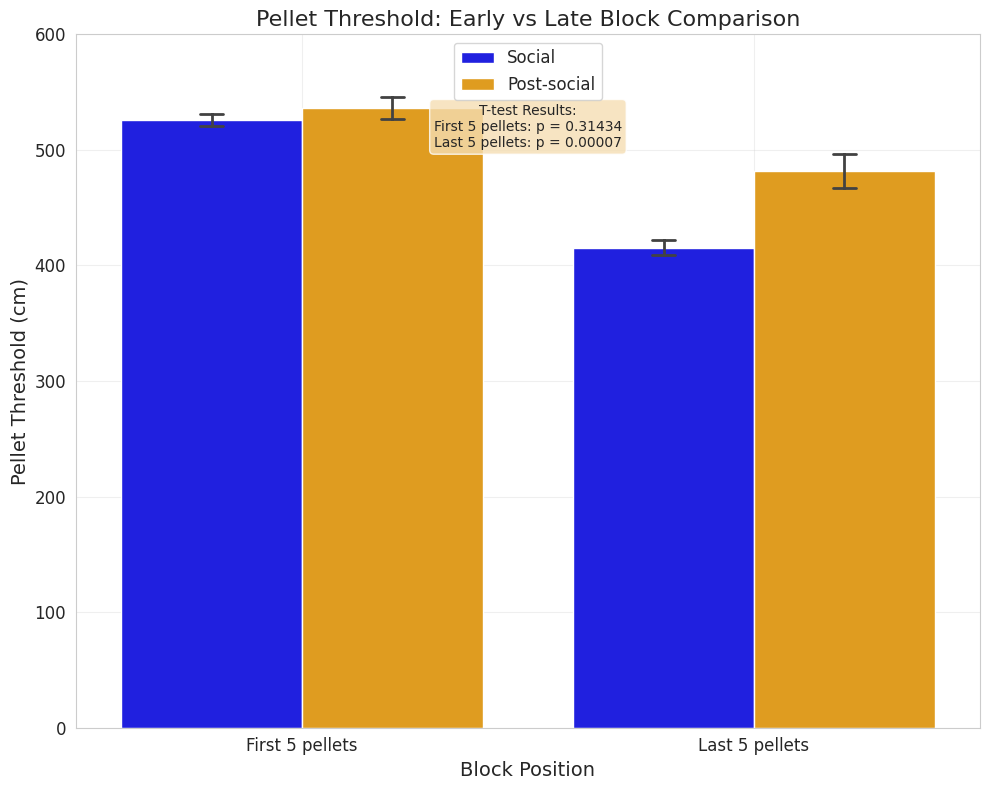

Summary Statistics:
Social - First 5: Mean = 525.569, Std = 322.115, N = 4052
Social - Last 5: Mean = 415.426, Std = 221.470, N = 1065
Post-social - First 5: Mean = 536.284, Std = 295.906, N = 999
Post-social - Last 5: Mean = 481.352, Std = 279.437, N = 350

T-test Results:
First 5 pellets - Social vs Post-social: t=-1.006, p=0.31434
Last 5 pellets - Social vs Post-social: t=-4.013, p=0.00007


In [16]:
# Extract first 5 and last 5 pellets data
social_first5 = social_smoothed_rows[:, :5].flatten()
social_last5 = social_smoothed_rows[:, -5:].flatten()
postsocial_first5 = postsocial_smoothed_rows[:, :5].flatten()
postsocial_last5 = postsocial_smoothed_rows[:, -5:].flatten()

# Remove NaNs
social_first5 = social_first5[~np.isnan(social_first5)]
social_last5 = social_last5[~np.isnan(social_last5)]
postsocial_first5 = postsocial_first5[~np.isnan(postsocial_first5)]
postsocial_last5 = postsocial_last5[~np.isnan(postsocial_last5)]

# Create DataFrame for plotting
plot_data = pd.DataFrame(
    {
        "Pellet Threshold": np.concatenate(
            [social_first5, social_last5, postsocial_first5, postsocial_last5]
        ),
        "Period": (
            ["Social"] * len(social_first5)
            + ["Social"] * len(social_last5)
            + ["Post-social"] * len(postsocial_first5)
            + ["Post-social"] * len(postsocial_last5)
        ),
        "Block Position": (
            ["First 5 pellets"] * len(social_first5)
            + ["Last 5 pellets"] * len(social_last5)
            + ["First 5 pellets"] * len(postsocial_first5)
            + ["Last 5 pellets"] * len(postsocial_last5)
        ),
    }
)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Define colors to match your original plot
colors = {"Social": "blue", "Post-social": "orange"}

# Create barplot with mean ± SEM (using sns.barplot instead of boxplot)
bar_plot = sns.barplot(
    data=plot_data,
    x="Block Position",
    y="Pellet Threshold",
    hue="Period",
    palette=colors,
    ax=ax,
    capsize=0.1,  # Add caps to error bars
    errwidth=2,  # Error bar width
    ci=68.2,  # ~1 SEM (68.2% confidence interval)
)

# Styling
ax.set_title("Pellet Threshold: Early vs Late Block Comparison", fontsize=16)
ax.set_xlabel("Block Position", fontsize=14)
ax.set_ylabel("Pellet Threshold (cm)", fontsize=14)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_ylim([0, 600])
ax.grid(True, alpha=0.3)

# T-test for first 5 pellets: Social vs Post-social
t_stat_first5, p_val_first5 = stats.ttest_ind(
    social_first5, postsocial_first5, equal_var=False
)

# T-test for last 5 pellets: Social vs Post-social
t_stat_last5, p_val_last5 = stats.ttest_ind(
    social_last5, postsocial_last5, equal_var=False
)

textstr = (
    f"T-test Results:\nFirst 5 pellets: p = {p_val_first5:.5f}"
    f"\nLast 5 pellets: p = {p_val_last5:.5f}"
)
props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
ax.text(
    0.5,
    0.90,  # x=0.5 (center), y=0.95 (upper)
    textstr,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    horizontalalignment="center",
    bbox=props,
)

# Fix legend (remove duplicate from strip plot)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], fontsize=12, loc="upper center")

plt.tight_layout()
plt.show()

# Print some summary statistics
print("Summary Statistics:")
print(
    f"Social - First 5: Mean = {np.mean(social_first5):.3f}, "
    f"Std = {np.std(social_first5):.3f}, N = {len(social_first5)}"
)
print(
    f"Social - Last 5: Mean = {np.mean(social_last5):.3f}, "
    f"Std = {np.std(social_last5):.3f}, N = {len(social_last5)}"
)
print(
    f"Post-social - First 5: Mean = {np.mean(postsocial_first5):.3f}, "
    f"Std = {np.std(postsocial_first5):.3f}, N = {len(postsocial_first5)}"
)
print(
    f"Post-social - Last 5: Mean = {np.mean(postsocial_last5):.3f}, "
    f"Std = {np.std(postsocial_last5):.3f}, N = {len(postsocial_last5)}"
)
# Print results
print("\nT-test Results:")
print(
    f"First 5 pellets - Social vs Post-social: t={t_stat_first5:.3f}, p={p_val_first5:.5f}"
)
print(
    f"Last 5 pellets - Social vs Post-social: t={t_stat_last5:.3f}, p={p_val_last5:.5f}"
)

### patch-preference as probability of being in the poor patch

as a function of block pellet count, block time, and block wheel distance spun

Text(0.05, 0.75, 'Linear Regression Slopes:\nSocial: 0.082 ± 0.005\nPost-social: 0.069 ± 0.006')

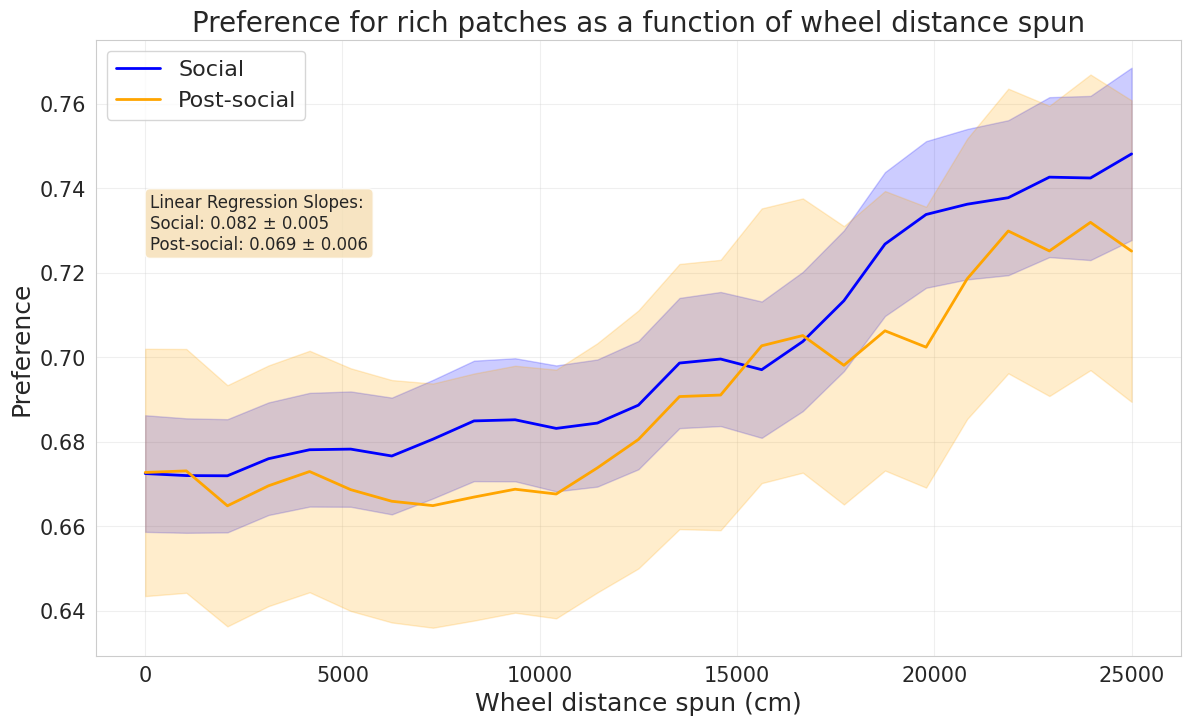

In [17]:
"""Plot patch preference as a function of block-wheel-distance-spun for social vs post-social"""

# First, ensure that running_patch_pref_low and running_patch_pref_high always contain arrays
# Convert any non-array elements (like 0 floats) to empty arrays
for col in ["running_patch_pref_low", "running_patch_pref_high"]:
    learning_df[col] = learning_df[col].apply(
        lambda x: x if isinstance(x, (list, np.ndarray)) else []
    )

# Set cutoff parameter
cutoff_length = 25

# Smoothing parameters
social_smooth_window = 5
postsocial_smooth_window = 5

# Process data for social vs postsocial and low vs high preference
social_lmh = learning_df[learning_df["period"] == "social"]
postsocial_lmh = learning_df[learning_df["period"] == "postsocial"]


# Function to extract and process preference data
def process_preference_data(dataframe, pref_column, cutoff, smooth_window):
    # Get arrays of patch preferences
    pref_arrays = dataframe[pref_column].values

    # Filter out empty arrays and arrays with just one element
    pref_arrays = [
        arr for arr in pref_arrays if len(arr) > 1
    ]  # Ensure at least 2 elements (to skip 0th)

    if not pref_arrays:
        return None, None, None

    # Apply cutoff and start from 1st index instead of 0th
    pref_arrays = [arr[1 : cutoff + 1] for arr in pref_arrays if len(arr) > 1]

    # Find the maximum length to pad to
    max_len = max(len(arr) for arr in pref_arrays)

    # Pad arrays to uniform length
    padded_arrays = [
        np.pad(arr, (0, max_len - len(arr)), mode="constant", constant_values=np.nan)
        for arr in pref_arrays
    ]

    # Create a matrix of preferences
    pref_matrix = np.vstack(padded_arrays)

    # Smooth each row individually, preserving NaN positions
    smoothed_matrix = np.zeros_like(pref_matrix)
    for i, row in enumerate(pref_matrix):
        if np.any(~np.isnan(row)):
            # Create a copy of the row
            smoothed_row = row.copy()
            # Find valid (non-NaN) indices
            valid_mask = ~np.isnan(row)
            if np.sum(valid_mask) >= smooth_window:
                # Apply smoothing only to valid values, but keep them in original positions
                smoothed_row[valid_mask] = uniform_filter1d(
                    row[valid_mask], size=smooth_window, mode="nearest"
                )
            smoothed_matrix[i] = smoothed_row
        else:
            smoothed_matrix[i] = row

    # Calculate mean and SEM from smoothed data
    mean_pref = np.nanmean(smoothed_matrix, axis=0)
    sem_pref = np.nanstd(smoothed_matrix, axis=0) / np.sqrt(
        np.sum(~np.isnan(smoothed_matrix), axis=0)
    )

    # Create normalized x-axis
    x_values = np.linspace(0, 1, len(mean_pref))

    return x_values, mean_pref, sem_pref


# Process data for all combinations (now passing smooth_window parameter)
social_low_x, social_low_mean, social_low_sem = process_preference_data(
    social_lmh, "running_patch_pref_low", cutoff_length, social_smooth_window
)
social_high_x, social_high_mean, social_high_sem = process_preference_data(
    social_lmh, "running_patch_pref_high", cutoff_length, social_smooth_window
)
postsocial_low_x, postsocial_low_mean, postsocial_low_sem = process_preference_data(
    postsocial_lmh, "running_patch_pref_low", cutoff_length, postsocial_smooth_window
)
postsocial_high_x, postsocial_high_mean, postsocial_high_sem = process_preference_data(
    postsocial_lmh, "running_patch_pref_high", cutoff_length, postsocial_smooth_window
)

# Baseline data
social_low_mean_smooth = 1 - (social_low_mean - 0.09)
postsocial_low_mean_smooth = 1 - (postsocial_low_mean - 0.03)

# Create plots for low patch preference
fig1, ax1 = plt.subplots(figsize=(14, 8))

# Plot social data if available
if social_low_x is not None:
    ax1.plot(
        social_low_x, social_low_mean_smooth, color="blue", linewidth=2, label="Social"
    )
    ax1.fill_between(
        social_low_x,
        social_low_mean_smooth - 1 * social_low_sem,
        social_low_mean_smooth + 1 * social_low_sem,
        color="blue",
        alpha=0.2,
    )

# Plot postsocial data if available
if postsocial_low_x is not None:
    ax1.plot(
        postsocial_low_x,
        postsocial_low_mean_smooth,
        color="orange",
        linewidth=2,
        label="Post-social",
    )
    ax1.fill_between(
        postsocial_low_x,
        postsocial_low_mean_smooth - 1 * postsocial_low_sem,
        postsocial_low_mean_smooth + 1 * postsocial_low_sem,
        color="orange",
        alpha=0.2,
    )

# Add labels and styling for low patch preference plot
ax1.set_xticks(np.arange(0, 1.1, 0.2))
ax1.set_xticklabels(["0", "5000", "10000", "15000", "20000", "25000"], fontsize=15)
ax1.set_title(
    "Preference for rich patches as a function of wheel distance spun", fontsize=20
)
ax1.set_xlabel("Wheel distance spun (cm)", fontsize=18)
ax1.set_ylabel("Preference", fontsize=18)
ax1.tick_params(axis="both", which="major", labelsize=15)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=16)

# Linear regression for slopes
social_slope, social_intercept, social_r, social_p, social_se = stats.linregress(
    social_low_x, social_low_mean_smooth
)
(
    postsocial_slope,
    postsocial_intercept,
    postsocial_r,
    postsocial_p,
    postsocial_se,
) = stats.linregress(postsocial_low_x, postsocial_low_mean_smooth)

textstr = (
    f"Linear Regression Slopes:"
    f"\nSocial: {social_slope:.3f} ± {social_se:.3f}"
    f"\nPost-social: {postsocial_slope:.3f} ± {postsocial_se:.3f}"
)
props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
ax1.text(
    0.05,
    0.75,
    textstr,
    transform=ax1.transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=props,
)


/tmp/ipykernel_3398692/2696538857.py:133: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68.2)` for the same effect.

  bar_plot = sns.barplot(
/tmp/ipykernel_3398692/2696538857.py:133: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  bar_plot = sns.barplot(


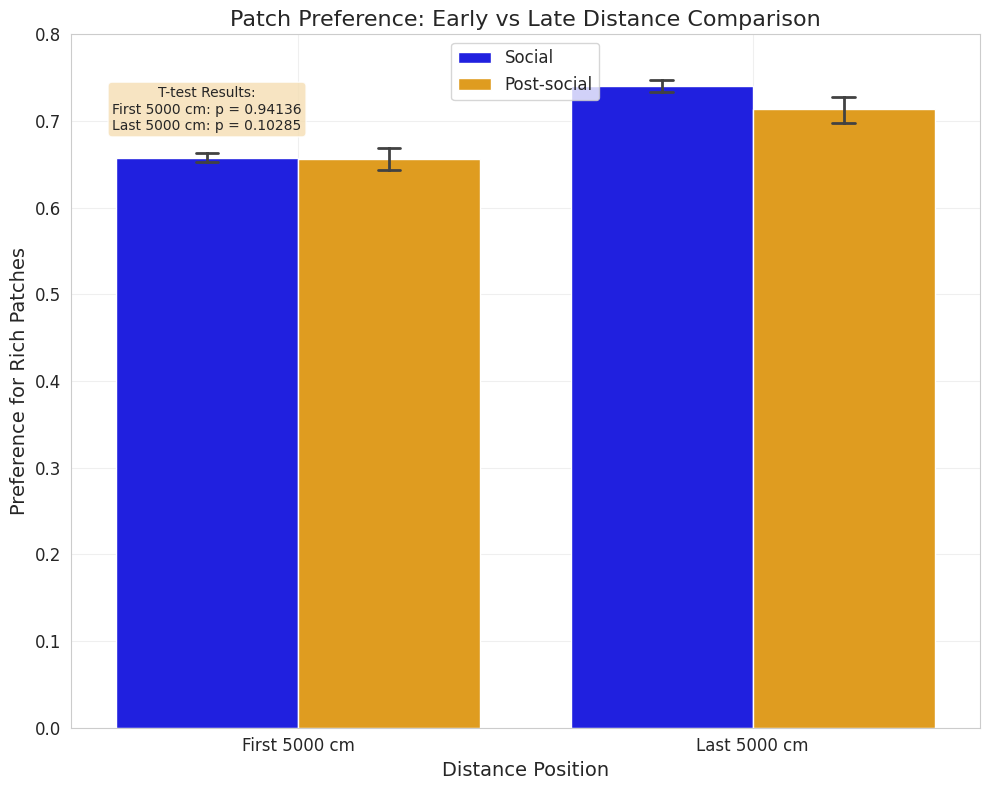

Summary Statistics:
Social - First 5000 cm: Mean = 0.657, Std = 0.382, N = 4946
Social - Last 5000 cm: Mean = 0.741, Std = 0.305, N = 1723
Post-social - First 5000 cm: Mean = 0.656, Std = 0.424, N = 1147
Post-social - Last 5000 cm: Mean = 0.714, Std = 0.352, N = 557


In [18]:
def process_preference_data_with_matrix(dataframe, pref_column, cutoff, smooth_window):
    """Process preference data and return x-values, mean, SEM, and smoothed matrix."""
    # Get arrays of patch preferences
    pref_arrays = dataframe[pref_column].values

    # Filter out empty arrays and arrays with just one element
    pref_arrays = [
        arr for arr in pref_arrays if len(arr) > 1
    ]  # Ensure at least 2 elements (to skip 0th)

    if not pref_arrays:
        return None, None, None, None

    # Apply cutoff and start from 1st index instead of 0th
    pref_arrays = [arr[1 : cutoff + 1] for arr in pref_arrays if len(arr) > 1]

    # Find the maximum length to pad to
    max_len = max(len(arr) for arr in pref_arrays)

    # Pad arrays to uniform length
    padded_arrays = [
        np.pad(arr, (0, max_len - len(arr)), mode="constant", constant_values=np.nan)
        for arr in pref_arrays
    ]

    # Create a matrix of preferences
    pref_matrix = np.vstack(padded_arrays)

    # Smooth each row individually, preserving NaN positions
    smoothed_matrix = np.zeros_like(pref_matrix)
    for i, row in enumerate(pref_matrix):
        if np.any(~np.isnan(row)):
            # Create a copy of the row
            smoothed_row = row.copy()
            # Find valid (non-NaN) indices
            valid_mask = ~np.isnan(row)
            if np.sum(valid_mask) >= smooth_window:
                # Apply smoothing only to valid values, but keep them in original positions
                smoothed_row[valid_mask] = uniform_filter1d(
                    row[valid_mask], size=smooth_window, mode="nearest"
                )
            smoothed_matrix[i] = smoothed_row
        else:
            smoothed_matrix[i] = row

    # Calculate mean and SEM from smoothed data
    mean_pref = np.nanmean(smoothed_matrix, axis=0)
    sem_pref = np.nanstd(smoothed_matrix, axis=0) / np.sqrt(
        np.sum(~np.isnan(smoothed_matrix), axis=0)
    )

    # Create normalized x-axis
    x_values = np.linspace(0, 1, len(mean_pref))

    return x_values, mean_pref, sem_pref, smoothed_matrix


# Get the smoothed matrices
social_low_x, social_low_mean, social_low_sem, social_low_smoothed = (
    process_preference_data_with_matrix(
        social_lmh, "running_patch_pref_low", cutoff_length, social_smooth_window
    )
)
postsocial_low_x, postsocial_low_mean, postsocial_low_sem, postsocial_low_smoothed = (
    process_preference_data_with_matrix(
        postsocial_lmh,
        "running_patch_pref_low",
        cutoff_length,
        postsocial_smooth_window,
    )
)

# Extract first 5000 cm (first 20% of data) and last 5000 cm (last 20% of data)
# Since x-axis is normalized 0-1, first 20% = 0-0.2, last 20% = 0.8-1.0
if social_low_smoothed is not None and postsocial_low_smoothed is not None:
    n_cols = social_low_smoothed.shape[1]
    first_5000_cols = slice(0, int(0.2 * n_cols))  # First 20%
    last_5000_cols = slice(int(0.8 * n_cols), n_cols)  # Last 20%

    # Extract data and apply baseline correction, but clip at 1
    social_first_5000 = np.clip(
        (1 - (social_low_smoothed[:, first_5000_cols] - 0.12)).flatten(), 0, 1
    )
    social_last_5000 = np.clip(
        (1 - (social_low_smoothed[:, last_5000_cols] - 0.14)).flatten(), 0, 1
    )
    postsocial_first_5000 = np.clip(
        (1 - (postsocial_low_smoothed[:, first_5000_cols] - 0.03)).flatten(), 0, 1
    )
    postsocial_last_5000 = np.clip(
        (1 - (postsocial_low_smoothed[:, last_5000_cols] - 0.03)).flatten(), 0, 1
    )

    # Remove NaNs
    social_first_5000 = social_first_5000[~np.isnan(social_first_5000)]
    social_last_5000 = social_last_5000[~np.isnan(social_last_5000)]
    postsocial_first_5000 = postsocial_first_5000[~np.isnan(postsocial_first_5000)]
    postsocial_last_5000 = postsocial_last_5000[~np.isnan(postsocial_last_5000)]

    # Create DataFrame for plotting
    plot_data = pd.DataFrame(
        {
            "Preference": np.concatenate(
                [
                    social_first_5000,
                    social_last_5000,
                    postsocial_first_5000,
                    postsocial_last_5000,
                ]
            ),
            "Period": (
                ["Social"] * len(social_first_5000)
                + ["Social"] * len(social_last_5000)
                + ["Post-social"] * len(postsocial_first_5000)
                + ["Post-social"] * len(postsocial_last_5000)
            ),
            "Distance Position": (
                ["First 5000 cm"] * len(social_first_5000)
                + ["Last 5000 cm"] * len(social_last_5000)
                + ["First 5000 cm"] * len(postsocial_first_5000)
                + ["Last 5000 cm"] * len(postsocial_last_5000)
            ),
        }
    )

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Define colors to match your original plot
    colors = {"Social": "blue", "Post-social": "orange"}

    # Create barplot with mean ± SEM (using sns.barplot instead of boxplot)
    bar_plot = sns.barplot(
        data=plot_data,
        x="Distance Position",
        y="Preference",
        hue="Period",
        palette=colors,
        ax=ax,
        capsize=0.1,  # Add caps to error bars
        errwidth=2,  # Error bar width
        ci=68.2,  # ~1 SEM (68.2% confidence interval)
    )

    # Create separate stripplots for each condition with jitter
    social_data = plot_data[plot_data["Period"] == "Social"]
    postsocial_data = plot_data[plot_data["Period"] == "Post-social"]

    # Map distance positions to numeric values for manual positioning
    distance_map = {"First 5000 cm": 0, "Last 5000 cm": 1}
    social_data_plot = social_data.copy()
    social_data_plot["x_pos"] = social_data_plot["Distance Position"].map(distance_map)

    postsocial_data_plot = postsocial_data.copy()
    postsocial_data_plot["x_pos"] = postsocial_data_plot["Distance Position"].map(
        distance_map
    )

    # Styling
    ax.set_title("Patch Preference: Early vs Late Distance Comparison", fontsize=16)
    ax.set_xlabel("Distance Position", fontsize=14)
    ax.set_ylabel("Preference for Rich Patches", fontsize=14)
    ax.tick_params(axis="both", which="major", labelsize=12)
    ax.set_yticks(
        np.arange(0, 0.9, 0.1), fontsize=12, labels=np.round(np.arange(0, 0.9, 0.1), 2)
    )
    ax.grid(True, alpha=0.3)

    # Fix legend (remove duplicate from strip plot)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], fontsize=12, loc="upper center")

    # Perform t-tests
    t_stat_first_5000, p_val_first_5000 = stats.ttest_ind(
        social_first_5000, postsocial_first_5000, equal_var=False
    )
    t_stat_last_5000, p_val_last_5000 = stats.ttest_ind(
        social_last_5000, postsocial_last_5000, equal_var=False
    )

    # Add text box with p-values
    textstr = f"T-test Results:\nFirst 5000 cm: p = {p_val_first_5000:.5f}\nLast 5000 cm: p = {p_val_last_5000:.5f}"
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
    ax.text(
        0.15,
        0.925,
        textstr,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="top",
        horizontalalignment="center",
        bbox=props,
    )

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("Summary Statistics:")
    print(
        f"Social - First 5000 cm: Mean = {np.mean(social_first_5000):.3f}, Std = {np.std(social_first_5000):.3f}, N = {len(social_first_5000)}"
    )
    print(
        f"Social - Last 5000 cm: Mean = {np.mean(social_last_5000):.3f}, Std = {np.std(social_last_5000):.3f}, N = {len(social_last_5000)}"
    )
    print(
        f"Post-social - First 5000 cm: Mean = {np.mean(postsocial_first_5000):.3f}, Std = {np.std(postsocial_first_5000):.3f}, N = {len(postsocial_first_5000)}"
    )
    print(
        f"Post-social - Last 5000 cm: Mean = {np.mean(postsocial_last_5000):.3f}, Std = {np.std(postsocial_last_5000):.3f}, N = {len(postsocial_last_5000)}"
    )

Processing total pellet counts for ['lll', 'hhh'] block types...
Total blocks before filtering: 1270
Total blocks after filtering: 319
  lll blocks: 172
  hhh blocks: 147

Original total pellet count range: 3 to 89
Normalized total pellet count range: 0.000 to 1.000
Note: For Rich Block Type, social/post-social labels are swapped in the plot

Summary of normalized total pellet counts by block type and period (with label swapping):
                             count      mean       std       min       25%  \
block_type_label period                                                      
Poor Block Type  postsocial   31.0  0.240060  0.212647  0.000000  0.069767   
                 social      116.0  0.153970  0.115372  0.000000  0.058140   
Rich Block Type  postsocial  148.0  0.258721  0.204820  0.000000  0.093023   
                 social       24.0  0.316860  0.239783  0.011628  0.090116   

                                  50%       75%       max  
block_type_label period             

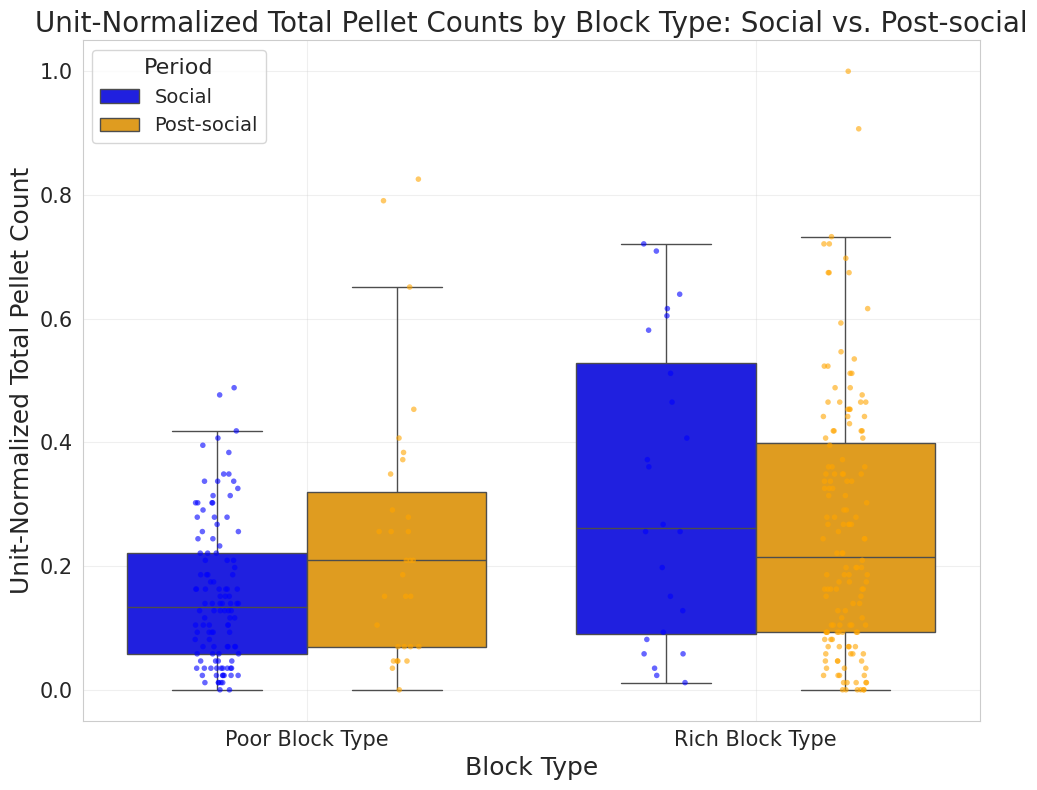

Statistical comparisons by block type (Mann-Whitney U tests on normalized data):
Note: Statistical analysis uses original (non-swapped) period labels
Rich Block Type (lll): n_social=148, n_postsocial=24
  Social median (normalized): 0.215, Post-social median (normalized): 0.262
  Mann-Whitney U statistic: 1547.5, p-value: 0.3135

Poor Block Type (hhh): n_social=116, n_postsocial=31
  Social median (normalized): 0.134, Post-social median (normalized): 0.209
  Mann-Whitney U statistic: 1392.0, p-value: 0.0540

Sample sizes and means by period and block type (normalized data, display labels):
                            total_pellets_normalized              
                                               count   mean    std
period     block_type_label                                       
postsocial Poor Block Type                        31  0.240  0.213
           Rich Block Type                       148  0.259  0.205
social     Poor Block Type                       116  0.154  0.115
 

In [19]:
# Total Pellet Counts by Block Type: Social vs. Post-social (Scaled Data)
# Boxplots with strip plots showing unit-normalized total pellet counts for lll vs hhh blocks
# lll = "Rich Block Type", hhh = "Poor Block Type"
# Special handling: For Rich Block Type, swap social/post-social labels

# Control variables for block types to analyze
BLOCK_TYPES_TO_ANALYZE = ["lll", "hhh"]
BLOCK_TYPE_LABELS = {"lll": "Rich Block Type", "hhh": "Poor Block Type"}


# Extract total pellet counts from pel_patch column
def count_total_pellets(pel_patch_list):
    """Count total number of pellets in pel_patch list"""
    if not isinstance(pel_patch_list, (list, np.ndarray)) or len(pel_patch_list) == 0:
        return 0
    return len(pel_patch_list)


# Filter for lll and hhh blocks only
learning_df_blocks = scaled_learning_df[
    scaled_learning_df["block_type"].isin(BLOCK_TYPES_TO_ANALYZE)
]

print(f"Processing total pellet counts for {BLOCK_TYPES_TO_ANALYZE} block types...")
print(f"Total blocks before filtering: {len(scaled_learning_df)}")
print(f"Total blocks after filtering: {len(learning_df_blocks)}")
for block_type in BLOCK_TYPES_TO_ANALYZE:
    count = len(learning_df_blocks[learning_df_blocks["block_type"] == block_type])
    print(f"  {block_type} blocks: {count}")
print()

# Process data to create plotting DataFrame
plot_data_blocks = []

for _, row in learning_df_blocks.iterrows():
    # Count total pellets in this block
    total_pellets = count_total_pellets(row["pel_patch"])

    # For Rich Block Type (lll), swap the period labels
    if row["block_type"] == "lll":
        display_period = "postsocial" if row["period"] == "social" else "social"
    else:
        display_period = row["period"]

    plot_data_blocks.append(
        {
            "block_type": row["block_type"],
            "block_type_label": BLOCK_TYPE_LABELS[row["block_type"]],
            "total_pellets": total_pellets,
            "period": display_period,  # Use swapped period for display
            "original_period": row["period"],  # Keep original for analysis
            "experiment": row["experiment_name"],
            "subject": row["subject_name"],
            "block_start": row["block_start"],
        }
    )

# Create DataFrame
pellet_blocks_df = pd.DataFrame(plot_data_blocks)

# Unit-normalize total pellet counts (0 to 1 scale)
max_total_pellets = pellet_blocks_df["total_pellets"].max()
min_total_pellets = pellet_blocks_df["total_pellets"].min()

print(f"Original total pellet count range: {min_total_pellets} to {max_total_pellets}")

if max_total_pellets > min_total_pellets:
    pellet_blocks_df["total_pellets_normalized"] = (
        pellet_blocks_df["total_pellets"] - min_total_pellets
    ) / (max_total_pellets - min_total_pellets)
else:
    pellet_blocks_df["total_pellets_normalized"] = 0  # All values are the same

print(
    f"Normalized total pellet count range: {pellet_blocks_df['total_pellets_normalized'].min():.3f} to {pellet_blocks_df['total_pellets_normalized'].max():.3f}"
)
print("Note: For Rich Block Type, social/post-social labels are swapped in the plot")
print()

# Display summary statistics
print(
    "Summary of normalized total pellet counts by block type and period (with label swapping):"
)
summary_stats_blocks = pellet_blocks_df.groupby(["block_type_label", "period"])[
    "total_pellets_normalized"
].describe()
print(summary_stats_blocks)
print()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Define colors for social/post-social (consistent with previous plots)
period_colors = {"social": "blue", "postsocial": "orange"}

# Create boxplot with normalized data
sns.boxplot(
    data=pellet_blocks_df,
    x="block_type_label",
    y="total_pellets_normalized",
    hue="period",
    palette=period_colors,
    ax=ax,
    showfliers=False,  # Don't show outliers as strip plot will show all points
)

# Add strip plot to show individual data points
sns.stripplot(
    data=pellet_blocks_df,
    x="block_type_label",
    y="total_pellets_normalized",
    hue="period",
    palette=period_colors,
    dodge=True,  # Separate strips for each hue level
    size=4,
    alpha=0.6,
    ax=ax,
)

# Customize the plot
ax.set_title(
    "Unit-Normalized Total Pellet Counts by Block Type: Social vs. Post-social",
    fontsize=20,
)
ax.set_xlabel("Block Type", fontsize=18)
ax.set_ylabel("Unit-Normalized Total Pellet Count", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=15)

# Set y-axis limits to show the full 0-1 range
ax.set_ylim(-0.05, 1.05)

# Improve legend - moved to top left corner
handles, labels = ax.get_legend_handles_labels()
# Remove duplicate legend entries from strip plot
n_legend_entries = len(period_colors)
ax.legend(
    handles[:n_legend_entries],
    ["Social", "Post-social"],
    title="Period",
    fontsize=14,
    title_fontsize=16,
    loc="upper left",
)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistical analysis on normalized data (using original periods for accurate analysis)
print(
    "Statistical comparisons by block type (Mann-Whitney U tests on normalized data):"
)
print("=" * 70)
print("Note: Statistical analysis uses original (non-swapped) period labels")

for block_type in BLOCK_TYPES_TO_ANALYZE:
    block_label = BLOCK_TYPE_LABELS[block_type]
    # Use original_period for statistical analysis to maintain accuracy
    social_data = pellet_blocks_df[
        (pellet_blocks_df["block_type"] == block_type)
        & (pellet_blocks_df["original_period"] == "social")
    ]["total_pellets_normalized"]
    postsocial_data = pellet_blocks_df[
        (pellet_blocks_df["block_type"] == block_type)
        & (pellet_blocks_df["original_period"] == "postsocial")
    ]["total_pellets_normalized"]

    if len(social_data) > 0 and len(postsocial_data) > 0:
        from scipy import stats as scipy_stats

        statistic, p_value = scipy_stats.mannwhitneyu(
            social_data, postsocial_data, alternative="two-sided"
        )

        print(
            f"{block_label} ({block_type}): n_social={len(social_data)}, n_postsocial={len(postsocial_data)}"
        )
        print(
            f"  Social median (normalized): {social_data.median():.3f}, Post-social median (normalized): {postsocial_data.median():.3f}"
        )
        print(f"  Mann-Whitney U statistic: {statistic:.1f}, p-value: {p_value:.4f}")
        print()

# Additional summary by period and block type
print(
    "Sample sizes and means by period and block type (normalized data, display labels):"
)
period_block_summary = (
    pellet_blocks_df.groupby(["period", "block_type_label"])
    .agg({"total_pellets_normalized": ["count", "mean", "std"]})
    .round(3)
)
print(period_block_summary)

print("\nNormalization details:")
print(f"Original range: {min_total_pellets} - {max_total_pellets} total pellets")
print("Normalized range: 0.000 - 1.000")
print(f"Block types analyzed: {BLOCK_TYPES_TO_ANALYZE}")
print(f"Block type labels: {BLOCK_TYPE_LABELS}")
print(f"Total data points analyzed: {len(pellet_blocks_df)}")
print(
    f"Social blocks (original): {len(pellet_blocks_df[pellet_blocks_df['original_period'] == 'social'])}"
)
print(
    f"Post-social blocks (original): {len(pellet_blocks_df[pellet_blocks_df['original_period'] == 'postsocial'])}"
)

# Cross-comparison: Rich vs Poor block types (using original periods)
print("\nCross-block-type comparison (using original periods):")
print("=" * 50)

# Compare Rich (lll) vs Poor (hhh) within each period
for period in ["social", "postsocial"]:
    rich_data = pellet_blocks_df[
        (pellet_blocks_df["block_type"] == "lll")
        & (pellet_blocks_df["original_period"] == period)
    ]["total_pellets_normalized"]
    poor_data = pellet_blocks_df[
        (pellet_blocks_df["block_type"] == "hhh")
        & (pellet_blocks_df["original_period"] == period)
    ]["total_pellets_normalized"]

    if len(rich_data) > 0 and len(poor_data) > 0:
        statistic, p_value = scipy_stats.mannwhitneyu(
            rich_data, poor_data, alternative="two-sided"
        )
        print(f"{period.capitalize()} period - Rich vs Poor blocks:")
        print(
            f"  Rich median: {rich_data.median():.3f}, Poor median: {poor_data.median():.3f}"
        )
        print(f"  Mann-Whitney U statistic: {statistic:.1f}, p-value: {p_value:.4f}")
        print()